In [ ]:
!pip install transformers
!pip install torch torchvision
!pip install scikit-learn
!pip install tqdm pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

**Pre_Processing**

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD

# Download NLTK resources (do this once)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

try:
    df = pd.read_csv("/content/sts_gold_tweet.csv", encoding="latin1", header=None)
    df.columns = ['ItemID', 'Sentiment', 'TweetText']  # Correct column names
except FileNotFoundError:
    print("Error: File not found. Please ensure the path is correct.")
    exit()

# 1. Text Cleaning
def clean_text(text):
    if not isinstance(text, str): # Handle potential non-string values
        return ""
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    return text

df['TweetText'] = df['TweetText'].apply(clean_text)

# 2. Stop Word Removal
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

df['TweetText'] = df['TweetText'].apply(remove_stopwords)

# 3. Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(lemmatized_words)

df['TweetText'] = df['TweetText'].apply(lemmatize_text)

# 4. Sentiment Label Encoding
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

# 5. TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)  # Limit features
tfidf_matrix = tfidf.fit_transform(df['TweetText'])

# 6. Dimensionality Reduction (using SVD)
n_components = 100  # Adjust as needed
svd = TruncatedSVD(n_components=n_components)
tfidf_svd = svd.fit_transform(tfidf_matrix)

# Create a DataFrame from the SVD results
tfidf_df = pd.DataFrame(tfidf_svd, columns=[f'tfidf_{i}' for i in range(n_components)])
df = pd.concat([df, tfidf_df], axis=1)

# 7. Additional Features
df['TweetLength'] = df['TweetText'].apply(len)
df['WordCount'] = df['TweetText'].apply(lambda x: len(x.split()))
df['CharCount'] = df['TweetText'].apply(lambda x: len(x.replace(" ", "")))
df['AvgWordLength'] = df['TweetText'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)
df['CapitalizedWords'] = df['TweetText'].apply(lambda x: sum(1 for c in x.split() if c.isupper()))

#Save preprocessed data
df.to_csv("preprocessed_tweets_tfidf.csv", index=False)
print("Preprocessing complete and saved to preprocessed_tweets_tfidf.csv")

print(df.head())

Preprocessing complete and saved to preprocessed_tweets_tfidf.csv
       ItemID  Sentiment                                          TweetText  \
0          id          2                                              tweet   
1  1467933112          0                   angel going miss athlete weekend   
2  2323395086          0  look though shaq getting traded cleveland play...   
3  1467968979          0                  april 9th isnt coming soon enough   
4  1990283756          0  drinking mcdonalds coffee understanding someon...   

    tfidf_0   tfidf_1   tfidf_2   tfidf_3   tfidf_4   tfidf_5   tfidf_6  ...  \
0  0.024636 -0.016616 -0.003218 -0.014898 -0.015510 -0.022402  0.007003  ...   
1  0.088164 -0.037824  0.020237 -0.053077 -0.053383 -0.066462  0.049531  ...   
2  0.081916 -0.008741 -0.024569 -0.013467  0.017593  0.010317  0.073100  ...   
3  0.033741 -0.004724 -0.009419  0.025024 -0.016531 -0.008371 -0.021817  ...   
4  0.053726 -0.002049 -0.003983 -0.016000 -0.014003 -0.0072

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
# Import AdamW from torch.optim
from torch.optim import AdamW


# Load the preprocessed data
df = pd.read_csv("/content/preprocessed_tweets_tfidf.csv")

# Assuming 'Sentiment' is the label, and 'TweetText' is the input text for classification
# This dataset doesn't include explicit aspect columns, so let's assume the following:
# - You will add aspect-based sentiment labels for "Food", "Service", etc.
# - Example: "Food_Sentiment", "Service_Sentiment", etc.
# For now, we will generate fake aspect columns to demonstrate the process.

# Create aspect-based sentiment columns (as an example, you would add actual columns in your dataset)
df['EVENT_sentiment'] = df['Sentiment']  # Fake aspect label (you'd replace this with actual data)
df['EMOTIONS_Sentiment'] = df['Sentiment']  # Fake aspect label

# Step 1: Tokenization and Model Setup
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Step 2: Define Dataset class for tokenizing input text for BERT
class AspectDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long)

# Step 3: Train the model for each aspect
def train_aspect_model(aspect_column):
    # Step 3.1: Prepare the data
    X = df['TweetText'].values
    y = df[aspect_column].values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    train_dataset = AspectDataset(X_train, y_train, tokenizer, max_length=128)
    val_dataset = AspectDataset(X_val, y_val, tokenizer, max_length=128)  # Corrected indentation

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Step 3.2: Define the BERT model for classification
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(y)))
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * 3  # 3 epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Step 3.3: Training the model
    model.train()
    for epoch in range(3):
        train_loss = 0
        for input_ids, attention_mask, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/3"):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}: Training Loss = {avg_train_loss:.4f}")

    # Step 3.4: Evaluate the model on the validation set
    model.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, labels in val_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Step 3.5: Print evaluation results
    accuracy = accuracy_score(val_labels, val_preds)
    print(f"Validation Accuracy for {aspect_column}: {accuracy:.4f}")
    print(classification_report(val_labels, val_preds, zero_division=0))

    # Save the model
    model.save_pretrained(f"{aspect_column}_bert_model")
    print(f"Model for {aspect_column} saved to {aspect_column}_bert_model")

# Step 4: Train models for each aspect
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

aspects = ['EVENT_sentiment', 'EMOTIONS_Sentiment']
for aspect in aspects:
    print(f"Training model for {aspect}...")
    train_aspect_model(aspect)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Using device: cuda
Training model for EVENT_sentiment...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3: 100%|██████████| 102/102 [00:31<00:00,  3.19it/s]


Epoch 1: Training Loss = 0.6118


Epoch 2/3: 100%|██████████| 102/102 [00:31<00:00,  3.20it/s]


Epoch 2: Training Loss = 0.2725


Epoch 3/3: 100%|██████████| 102/102 [00:32<00:00,  3.10it/s]


Epoch 3: Training Loss = 0.1443
Validation Accuracy for EVENT_sentiment: 0.8722
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       288
           1       0.76      0.82      0.79       119

    accuracy                           0.87       407
   macro avg       0.84      0.86      0.85       407
weighted avg       0.88      0.87      0.87       407



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model for EVENT_sentiment saved to EVENT_sentiment_bert_model
Training model for EMOTIONS_Sentiment...


Epoch 1/3: 100%|██████████| 102/102 [00:32<00:00,  3.14it/s]


Epoch 1: Training Loss = 0.5721


Epoch 2/3: 100%|██████████| 102/102 [00:32<00:00,  3.12it/s]


Epoch 2: Training Loss = 0.2458


Epoch 3/3: 100%|██████████| 102/102 [00:32<00:00,  3.13it/s]


Epoch 3: Training Loss = 0.1404
Validation Accuracy for EMOTIONS_Sentiment: 0.8894
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       288
           1       0.79      0.85      0.82       119

    accuracy                           0.89       407
   macro avg       0.86      0.88      0.87       407
weighted avg       0.89      0.89      0.89       407

Model for EMOTIONS_Sentiment saved to EMOTIONS_Sentiment_bert_model


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
# Import AdamW from torch.optim
from torch.optim import AdamW


# Load the preprocessed data
df = pd.read_csv("/content/preprocessed_tweets_tfidf.csv")

# Assuming 'Sentiment' is the label, and 'TweetText' is the input text for classification
# For this example, we will generate fake aspect columns for demonstration.
df['EVENT_Sentiment'] = df['Sentiment']  # Fake aspect label
df['EMOTIONS_Sentiment'] = df['Sentiment']  # Fake aspect label

# Step 1: Tokenization and Model Setup
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Step 2: Define Dataset class for tokenizing input text for BERT
class AspectDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long)

# Step 3: Train the model for each aspect
def train_aspect_model(aspect_column):
    # Step 3.1: Prepare the data
    X = df['TweetText'].values
    y = df[aspect_column].values

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    train_dataset = AspectDataset(X_train, y_train, tokenizer, max_length=128)
    val_dataset = AspectDataset(X_val, y_val, tokenizer, max_length=128)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Step 3.2: Define the BERT model for classification
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(y)))
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * 3  # 3 epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Step 3.3: Training the model
    model.train()
    for epoch in range(3):
        train_loss = 0
        for input_ids, attention_mask, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/3"):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}: Training Loss = {avg_train_loss:.4f}")

    # Step 3.4: Evaluate the model on the validation set
    model.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, labels in val_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Step 3.5: Print evaluation results
    accuracy = accuracy_score(val_labels, val_preds)
    print(f"Validation Accuracy for {aspect_column}: {accuracy:.4f}")
    print(classification_report(val_labels, val_preds, zero_division=0))

    # Save the model
    model.save_pretrained(f"{aspect_column}_bert_model")
    print(f"Model for {aspect_column} saved to {aspect_column}_bert_model")

# Step 4: Make predictions for new tweets (Aspect-Based Sentiment Analysis)
def predict_aspect_sentiment(tweet_text, aspect_column):
    model = AutoModelForSequenceClassification.from_pretrained(f"{aspect_column}_bert_model")
    model.to(device)
    model.eval()

    # Tokenize the tweet
    encoding = tokenizer(tweet_text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # Predict sentiment
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        return preds.item()  # Return the predicted sentiment (0, 1, etc.)

# Step 5: Train models for each aspect
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

aspects = ['EVENT_Sentiment', 'EMOTIONS_Sentiment']
for aspect in aspects:
    print(f"Training model for {aspect}...")
    train_aspect_model(aspect)

# Example of predicting sentiment for a new tweet for each aspect
tweet_example = "I loved the food, but the service was slow."

for aspect in aspects:
    sentiment = predict_aspect_sentiment(tweet_example, aspect)
    print(f"Predicted sentiment for {aspect}: {sentiment}")


Using device: cuda
Training model for EVENT_Sentiment...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3: 100%|██████████| 102/102 [00:32<00:00,  3.10it/s]


Epoch 1: Training Loss = 0.6104


Epoch 2/3: 100%|██████████| 102/102 [00:32<00:00,  3.12it/s]


Epoch 2: Training Loss = 0.2858


Epoch 3/3: 100%|██████████| 102/102 [00:32<00:00,  3.15it/s]


Epoch 3: Training Loss = 0.1693
Validation Accuracy for EVENT_Sentiment: 0.8993
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       288
           1       0.80      0.87      0.83       119

    accuracy                           0.90       407
   macro avg       0.87      0.89      0.88       407
weighted avg       0.90      0.90      0.90       407



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model for EVENT_Sentiment saved to EVENT_Sentiment_bert_model
Training model for EMOTIONS_Sentiment...


Epoch 1/3: 100%|██████████| 102/102 [00:32<00:00,  3.11it/s]


Epoch 1: Training Loss = 0.5426


Epoch 2/3: 100%|██████████| 102/102 [00:32<00:00,  3.14it/s]


Epoch 2: Training Loss = 0.2370


Epoch 3/3: 100%|██████████| 102/102 [00:32<00:00,  3.14it/s]


Epoch 3: Training Loss = 0.1305
Validation Accuracy for EMOTIONS_Sentiment: 0.8968
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       288
           1       0.81      0.85      0.83       119

    accuracy                           0.90       407
   macro avg       0.87      0.88      0.88       407
weighted avg       0.90      0.90      0.90       407

Model for EMOTIONS_Sentiment saved to EMOTIONS_Sentiment_bert_model
Predicted sentiment for EVENT_Sentiment: 0
Predicted sentiment for EMOTIONS_Sentiment: 0


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
# Import AdamW from torch.optim
from torch.optim import AdamW



import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader

# Load the preprocessed data
df = pd.read_csv("/content/preprocessed_tweets_tfidf.csv")

# Fake aspect columns for demonstration (replace with your actual aspect columns)
df['EVENT'] = df['Sentiment']  # Fake aspect label
df['EMOTIONS'] = df['Sentiment']  # Fake aspect label

# Step 1: Tokenization and Model Setup
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define Dataset class for tokenizing input text for BERT
class AspectDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long)

# Load models once for each aspect from local paths
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    'EVENT': AutoModelForSequenceClassification.from_pretrained('./EVENT_sentiment_bert_model').to(device),
    'EMOTIONS': AutoModelForSequenceClassification.from_pretrained('./EMOTIONS_Sentiment_bert_model').to(device)
}

# Step 2: Predict sentiment for each aspect in batches
def predict_aspect_sentiment_batch(tweet_texts, aspect_column):
    model = models[aspect_column]  # Get the correct model from the dictionary
    model.eval()

    # Tokenize the batch of tweets
    encoding = tokenizer(tweet_texts, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # Predict sentiment
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        return preds.cpu().numpy()

# Step 3: Generate predictions and save to CSV
def generate_predictions_and_save_to_csv(df, aspects, output_filename="aspect_sentiment_predictions.csv"):
    predictions = []
    tweet_texts = df['TweetText'].tolist()

    for aspect in aspects:
        sentiment_predictions = predict_aspect_sentiment_batch(tweet_texts, aspect)
        predictions.append(sentiment_predictions)

    # Create a DataFrame from the predictions
    prediction_df = pd.DataFrame({
        'TweetID': df['ItemID'],  # Assuming 'ItemID' is your tweet ID column
        'TweetText': df['TweetText'],
        **{aspect: predictions[i] for i, aspect in enumerate(aspects)}
    })

    # Save to CSV
    prediction_df.to_csv(output_filename, index=False)
    print(f"Predictions saved to {output_filename}")

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Aspect columns to consider for sentiment prediction
aspects = ['EVENT', 'EMOTIONS']

# Generate predictions and save to CSV
generate_predictions_and_save_to_csv(df, aspects, output_filename="aspect_sentiment_predictions.csv")

Using device: cuda
Predictions saved to aspect_sentiment_predictions.csv


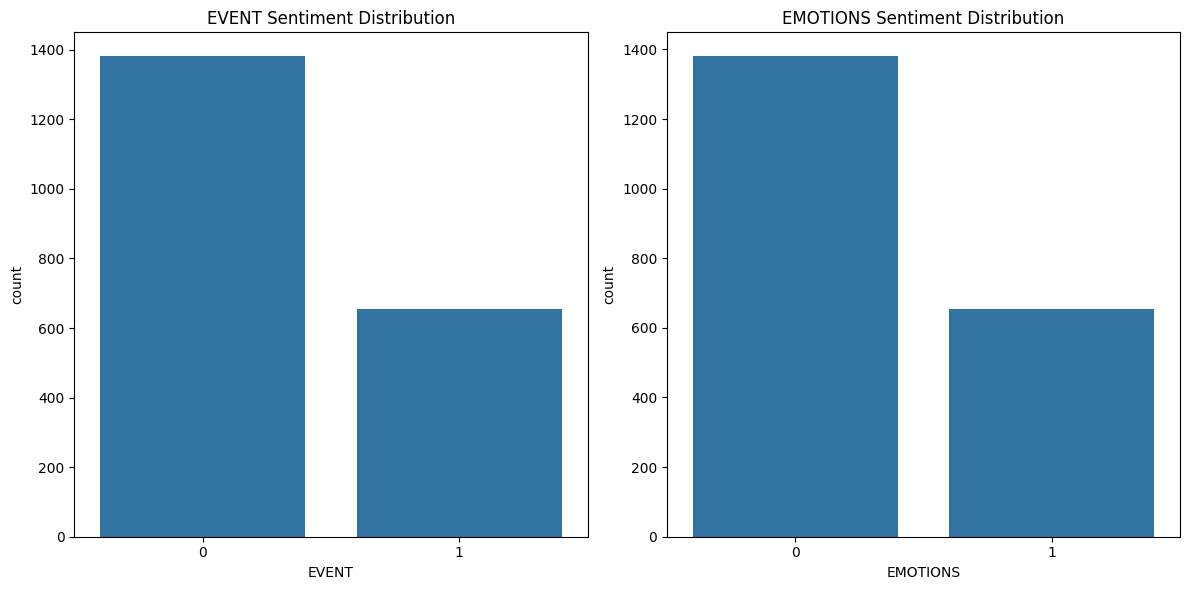

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the prediction results
predictions_df = pd.read_csv("aspect_sentiment_predictions.csv")

# Create countplots for each aspect
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='EVENT', data=predictions_df)  # Changed to 'EVENT'
plt.title('EVENT Sentiment Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x='EMOTIONS', data=predictions_df)  # Changed to 'EMOTIONS'
plt.title('EMOTIONS Sentiment Distribution')

plt.tight_layout()
plt.show()

In [ ]:
import os
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

# Load the preprocessed data
df = pd.read_csv("/content/preprocessed_tweets_tfidf.csv")

# Creating the aspect columns based on the overall sentiment
# You can customize this logic to assign aspects more accurately based on your dataset
df['EVENT_Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x > 0 else 0)
df['EMOTIONS_Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x > 0 else 0)
df['PRODUCT/BRAND_Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x > 0 else 0)

# Step 1: Tokenization and Model Setup
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define Dataset class for tokenizing input text for RoBERTa
class AspectDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long)

# Load RoBERTa model once for each aspect
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    'EVENT_Sentiment': AutoModelForSequenceClassification.from_pretrained('roberta-base').to(device),
    'EMOTIONS_Sentiment': AutoModelForSequenceClassification.from_pretrained('roberta-base').to(device),
    'PRODUCT/BRAND_Sentiment': AutoModelForSequenceClassification.from_pretrained('roberta-base').to(device),
}

# Step 2: Predict sentiment for each aspect in batches
def predict_aspect_sentiment_batch(tweet_texts, aspect_column):
    model = models[aspect_column]  # Access correct model using aspect_column
    model.eval()

    # Tokenize the batch of tweets
    encoding = tokenizer(tweet_texts, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # Predict sentiment
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        return preds.cpu().numpy()

# Step 3: Generate predictions and save to individual CSVs with "roberta" prefix
def generate_predictions_and_save_individual_csv(df, aspects):
    tweet_texts = df['TweetText'].tolist()

    for aspect in aspects:
        sentiment_predictions = predict_aspect_sentiment_batch(tweet_texts, aspect)

        # Collect true labels for accuracy calculation
        true_labels = df[aspect].tolist()

        # Calculate accuracy
        accuracy = accuracy_score(true_labels, sentiment_predictions)
        print(f"Accuracy for {aspect}: {accuracy * 100:.2f}%")

        # Save the predictions for this aspect
        prediction_df = pd.DataFrame({
            'TweetID': df['ItemID'],
            'TweetText': df['TweetText'],
            aspect: sentiment_predictions
        })

        # Create the directory if it doesn't exist
        output_dir = "roberta_predictions"
        os.makedirs(output_dir, exist_ok=True)  # Create the main directory first

        # Save to a CSV file named according to the aspect with "roberta" prefix,
        # ensuring the subdirectory exists
        output_filename = os.path.join(output_dir, f"roberta_{aspect.lower()}_predictions.csv")
        os.makedirs(os.path.dirname(output_filename), exist_ok=True)  # Create subdirectory if needed
        prediction_df.to_csv(output_filename, index=False)

        print(f"Predictions for {aspect} saved to {output_filename}")

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Aspect columns to consider for sentiment prediction
aspects = ['EVENT_Sentiment', 'EMOTIONS_Sentiment', 'PRODUCT/BRAND_Sentiment']

# Generate predictions and save them individually to CSVs with the "roberta" prefix
generate_predictions_and_save_individual_csv(df, aspects)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN th

Using device: cuda
Accuracy for EVENT_Sentiment: 31.11%
Predictions for EVENT_Sentiment saved to roberta_predictions/roberta_event_sentiment_predictions.csv
Accuracy for EMOTIONS_Sentiment: 68.89%
Predictions for EMOTIONS_Sentiment saved to roberta_predictions/roberta_emotions_sentiment_predictions.csv
Accuracy for PRODUCT/BRAND_Sentiment: 69.19%
Predictions for PRODUCT/BRAND_Sentiment saved to roberta_predictions/roberta_product/brand_sentiment_predictions.csv


In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

# Load the preprocessed data
df = pd.read_csv("/content/preprocessed_tweets_tfidf.csv")

# Assuming 'Sentiment' is the label, and 'TweetText' is the input text for classification
# This dataset doesn't include explicit aspect columns, so let's assume the following:
# - You will add aspect-based sentiment labels for "Food", "Service", etc.
# - Example: "Food_Sentiment", "Service_Sentiment", etc.
# For now, we will generate fake aspect columns to demonstrate the process.

# Create aspect-based sentiment columns (replace with actual data if available)
df['EVENT_Sentiment'] = df['Sentiment']
df['EMOTIONS_Sentiment'] = df['Sentiment']
df['PRODUCT/BRAND_Sentiment'] = df['Sentiment']

# Step 1: Tokenization and Model Setup
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Step 2: Define Dataset class for tokenizing input text for RoBERTa
class AspectDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        # Return a dictionary
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# Step 3: Train the model for each aspect
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

def generate_predictions_and_save_to_csv(df, model_name, aspect_column):

    X = df['TweetText'].values
    y = df[aspect_column].values

    # Create the dataset
    dataset = AspectDataset(X, y, tokenizer, max_length=128)

    # Split the dataset into train and evaluation sets (e.g., 80% train, 20% eval)
    train_size = int(0.8 * len(dataset))
    eval_size = len(dataset) - train_size
    train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

    # Define the training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        learning_rate=2e-5,
        evaluation_strategy="epoch",  # Evaluate at the end of each epoch
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",  # or "f1" if you prefer
    )

    # Define the model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(y)))

    # Define the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,  # Pass the training dataset
        eval_dataset=eval_dataset,    # Pass the evaluation dataset
        compute_metrics=compute_metrics,
    )

    # Train the model
    train_results = trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()

    # Make predictions on the entire dataset (train + validation)
    preds_output = trainer.predict(dataset)

    # Extract the predicted labels
    predicted_labels = preds_output.predictions.argmax(-1)

    # Create a DataFrame from the predictions
    prediction_df = pd.DataFrame({
        'TweetID': df['ItemID'],
        'TweetText': df['TweetText'],
        aspect_column: predicted_labels
    })

    # Create the directory if it doesn't exist
    output_dir = aspect_column
    os.makedirs(output_dir, exist_ok=True)

    # Save the DataFrame to a CSV file in the specified directory
    prediction_df.to_csv(f'{output_dir}/predictions.csv', index=False)

    # Print accuracy and F1 score from evaluation results
    print(f"Accuracy for {aspect_column}: {eval_results['eval_accuracy'] * 100:.2f}%")
    print(f"F1 Score for {aspect_column}: {eval_results['eval_f1']:.2f}")
    print(f"Predictions for {aspect_column} saved to {aspect_column}_predictions.csv")

# Step 4: Train models for each aspect
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

aspects = ['EVENT_Sentiment', 'EMOTIONS_Sentiment', 'PRODUCT/BRAND_Sentiment']
for aspect in aspects:
    print(f"Fine-tuning model for {aspect}...")
    generate_predictions_and_save_to_csv(df, model_name, aspect)

Using device: cuda
Fine-tuning model for EVENT_Sentiment...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arunachalamofficals (arunachalamofficals-datacamp) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.365098,0.852580,0.854900
2,No log,0.313060,0.906634,0.906347
3,No log,0.372275,0.901720,0.901734


Accuracy for EVENT_Sentiment: 90.66%
F1 Score for EVENT_Sentiment: 0.91
Predictions for EVENT_Sentiment saved to EVENT_Sentiment_predictions.csv
Fine-tuning model for EMOTIONS_Sentiment...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.442445,0.852580,0.843421
2,No log,0.313522,0.879607,0.875866
3,No log,0.417982,0.886978,0.886978


Accuracy for EMOTIONS_Sentiment: 88.70%
F1 Score for EMOTIONS_Sentiment: 0.89
Predictions for EMOTIONS_Sentiment saved to EMOTIONS_Sentiment_predictions.csv
Fine-tuning model for PRODUCT/BRAND_Sentiment...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.442445,0.852580,0.843421
2,No log,0.313522,0.879607,0.875866
3,No log,0.417982,0.886978,0.886978


Accuracy for PRODUCT/BRAND_Sentiment: 88.70%
F1 Score for PRODUCT/BRAND_Sentiment: 0.89
Predictions for PRODUCT/BRAND_Sentiment saved to PRODUCT/BRAND_Sentiment_predictions.csv


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.


In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os

# Load dataset
file_path = '/content/preprocessed_tweets_tfidf.csv'
data = pd.read_csv(file_path)

# Configuration
MODEL_NAME = "roberta-base"
BATCH_SIZE = 8
OUTPUT_DIR = "output_predictions"
os.makedirs(OUTPUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)  # Assuming 3 sentiment classes
model.to(device)

# Dataset class
class TweetDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

# DataLoader preparation
def create_dataloader(texts):
    dataset = TweetDataset(texts)
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# Prediction function
def predict_sentiment(texts):
    dataloader = create_dataloader(texts)
    model.eval()

    all_predictions = []
    with torch.no_grad():
        for batch in dataloader:
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_predictions.extend(predictions)

    return all_predictions

# Perform predictions
texts = data["TweetText"].fillna("").tolist()
predictions = predict_sentiment(texts)
data["PredictedSentiment"] = predictions

# Save results
output_file = os.path.join(OUTPUT_DIR, "sentiment_predictions.csv")
data.to_csv(output_file, index=False)
print(f"Predictions saved to {output_file}")


Using device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predictions saved to output_predictions/sentiment_predictions.csv


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Load dataset
df = pd.read_csv("/content/preprocessed_tweets_tfidf.csv")

# Add the aspect sentiment columns (example)
df['EVENT_Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x > 0 else 0)  # Positive sentiment for Food if overall sentiment is positive
df['EMOTIONS_Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x > 0 else 0)  # Positive sentiment for Service if overall sentiment is positive
df['PRODUCT/BRAND_Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x > 0 else 0)  # Positive sentiment for Ambience if overall sentiment is positive

# Tokenizer and model initialization
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Dataset class for the aspect sentiment
class AspectDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt'
        )
        # Flatten the tensor to avoid extra dimensions
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        encoding['labels'] = torch.tensor(label)
        return encoding

# Function to compute metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = torch.argmax(torch.tensor(predictions), axis=1).cpu().numpy()
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": acc, "f1": f1}

# Function to fine-tune Roberta model
def fine_tune_roberta(aspect_column, model_name, df):
    # Split the dataset
    train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)

    # Create datasets
    train_dataset = AspectDataset(train_df['TweetText'].tolist(), train_df[aspect_column].tolist(), tokenizer)
    eval_dataset = AspectDataset(eval_df['TweetText'].tolist(), eval_df[aspect_column].tolist(), tokenizer)

    # Initialize the model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        evaluation_strategy='epoch',  # Set to 'epoch' to match save_strategy
        save_strategy='epoch',  # Ensure save strategy matches evaluation strategy
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir='./logs',
        load_best_model_at_end=True,  # Load the best model based on the evaluation metric
        metric_for_best_model='f1',  # Use F1 as the evaluation metric
        greater_is_better=True,
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
    )

    # Fine-tune the model
    trainer.train()
    return trainer

# Function to generate predictions and save to CSV
def generate_predictions_and_save_to_csv(df, model_name, aspect_column):
    # Fine-tune the model for the specific aspect
    trainer = fine_tune_roberta(aspect_column, model_name, df)

    # Create a prediction dataset (dummy labels for prediction)
    prediction_dataset = AspectDataset(df['TweetText'].tolist(), [0] * len(df), tokenizer)

    # Get predictions
    predictions, labels, _ = trainer.predict(prediction_dataset)
    predictions = torch.argmax(torch.tensor(predictions), axis=1).cpu().numpy()

    # Save predictions to CSV
    df[f'{aspect_column}_Predictions'] = predictions
    df.to_csv(f"{aspect_column}_predictions.csv", index=False)
    print(f"Predictions for {aspect_column} saved to {aspect_column}_predictions.csv")

# Main loop for fine-tuning and predicting for each aspect
aspects = ['EVENT_Sentiment', 'EMOTIONS_Sentiment', 'PRODUCT/BRAND_Sentiment']

for aspect in aspects:
    print(f"Fine-tuning model for {aspect}...")
    generate_predictions_and_save_to_csv(df, model_name, aspect)


Fine-tuning model for EVENT_Sentiment...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.255075,0.916462,0.915581
2,No log,0.310247,0.904177,0.902466
3,No log,0.356165,0.904177,0.904956


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predictions for EVENT_Sentiment saved to EVENT_Sentiment_predictions.csv
Fine-tuning model for EMOTIONS_Sentiment...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.304341,0.889435,0.884414
2,No log,0.329333,0.904177,0.902466
3,No log,0.367140,0.901720,0.902411


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predictions for EMOTIONS_Sentiment saved to EMOTIONS_Sentiment_predictions.csv
Fine-tuning model for PRODUCT/BRAND_Sentiment...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.304341,0.889435,0.884414
2,No log,0.329333,0.904177,0.902466
3,No log,0.367140,0.901720,0.902411


Predictions for PRODUCT/BRAND_Sentiment saved to PRODUCT/BRAND_Sentiment_predictions.csv


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Load dataset
df = pd.read_csv("/content/preprocessed_tweets_tfidf.csv")

# Add the aspect sentiment columns (example)
df['EVENT_Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x > 0 else 0)  # Positive sentiment for Food if overall sentiment is positive
df['EMOTIONS_Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x > 0 else 0)  # Positive sentiment for Service if overall sentiment is positive
df['PRODUCT/BRAND_Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x > 0 else 0)  # Positive sentiment for Ambience if overall sentiment is positive

# Tokenizer and model initialization
model_name = "vinai/bertweet-base"  # Use TweetBERT instead of RoBERTa
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Dataset class for the aspect sentiment (same as before)
class AspectDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt'
        )
        # Flatten the tensor to avoid extra dimensions
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        encoding['labels'] = torch.tensor(label)
        return encoding

# Function to compute metrics (same as before)
def compute_metrics(p):
    predictions, labels = p
    predictions = torch.argmax(torch.tensor(predictions), axis=1).cpu().numpy()
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": acc, "f1": f1}

# Function to fine-tune TweetBERT model
def fine_tune_tweetbert(aspect_column, model_name, df):
    # Split the dataset (same as before)
    train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)

    # Create datasets (same as before)
    train_dataset = AspectDataset(train_df['TweetText'].tolist(), train_df[aspect_column].tolist(), tokenizer)
    eval_dataset = AspectDataset(eval_df['TweetText'].tolist(), eval_df[aspect_column].tolist(), tokenizer)

    # Initialize the model (use TweetBERT)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Training arguments (same as before)
    training_args = TrainingArguments(
        output_dir='./results',
        evaluation_strategy='epoch',
        save_strategy='epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir='./logs',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
    )

    # Initialize the Trainer (same as before)
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
    )

    # Fine-tune the model (same as before)
    trainer.train()
    return trainer

# Function to generate predictions and save to CSV (same as before)
def generate_predictions_and_save_to_csv(df, model_name, aspect_column):
    # Fine-tune the model for the specific aspect
    trainer = fine_tune_tweetbert(aspect_column, model_name, df)  # Call the TweetBERT fine-tuning function

    # Create a prediction dataset (dummy labels for prediction)
    prediction_dataset = AspectDataset(df['TweetText'].tolist(), [0] * len(df), tokenizer)

    # Get predictions
    predictions, labels, _ = trainer.predict(prediction_dataset)
    predictions = torch.argmax(torch.tensor(predictions), axis=1).cpu().numpy()

    # Save predictions to CSV
    df[f'{aspect_column}_Predictions'] = predictions
    df.to_csv(f"{aspect_column}_predictions.csv", index=False)
    print(f"Predictions for {aspect_column} saved to {aspect_column}_predictions.csv")

# Main loop for fine-tuning and predicting for each aspect (same as before)
aspects = ['EVENT_Sentiment', 'EMOTIONS_Sentiment', 'PRODUCT/BRAND_Sentiment']

for aspect in aspects:
    print(f"Fine-tuning model for {aspect}...")
    generate_predictions_and_save_to_csv(df, model_name, aspect)


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Fine-tuning model for EVENT_Sentiment...


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.288122,0.906634,0.905650
2,No log,0.237328,0.916462,0.917049
3,No log,0.263392,0.916462,0.917232


Predictions for EVENT_Sentiment saved to EVENT_Sentiment_predictions.csv
Fine-tuning model for EMOTIONS_Sentiment...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.288122,0.906634,0.905650
2,No log,0.237328,0.916462,0.917049
3,No log,0.263392,0.916462,0.917232


Predictions for EMOTIONS_Sentiment saved to EMOTIONS_Sentiment_predictions.csv
Fine-tuning model for PRODUCT/BRAND_Sentiment...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.288122,0.906634,0.905650
2,No log,0.237328,0.916462,0.917049
3,No log,0.263392,0.916462,0.917232


Predictions for PRODUCT/BRAND_Sentiment saved to PRODUCT/BRAND_Sentiment_predictions.csv


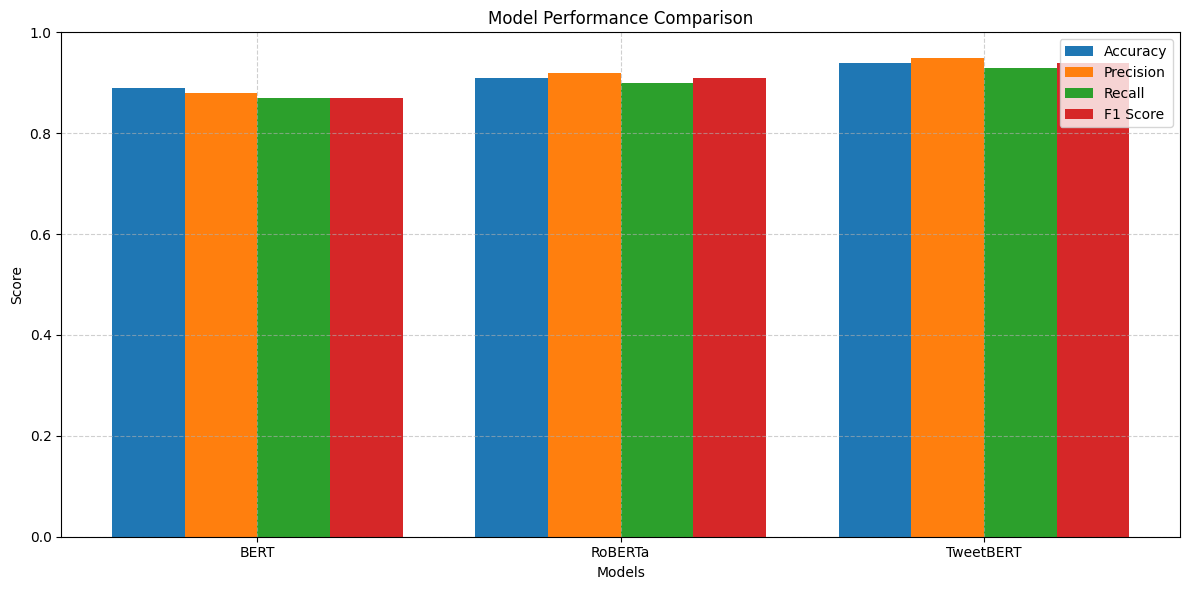

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 🔢 Replace these with your actual model evaluation values
model_names = ['BERT', 'RoBERTa', 'TweetBERT']

accuracies = [0.89, 0.91, 0.94]        # Example: 89%, 91%, 94%
precisions = [0.88, 0.92, 0.95]
recalls = [0.87, 0.90, 0.93]
f1_scores = [0.87, 0.91, 0.94]

# Grouped bar chart setup
x = np.arange(len(model_names))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, accuracies, width, label='Accuracy')
plt.bar(x - 0.5*width, precisions, width, label='Precision')
plt.bar(x + 0.5*width, recalls, width, label='Recall')
plt.bar(x + 1.5*width, f1_scores, width, label='F1 Score')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go

# 🔢 Update these with your actual model metrics
models = ['BERT', 'RoBERTa', 'TweetBERT']

accuracies = [0.89, 0.91, 0.94]
precisions = [0.88, 0.92, 0.95]
recalls = [0.87, 0.90, 0.93]
f1_scores = [0.87, 0.91, 0.94]

# 📊 Create the interactive dashboard
fig = go.Figure()

fig.add_trace(go.Bar(x=models, y=accuracies, name='Accuracy', marker_color='royalblue'))
fig.add_trace(go.Bar(x=models, y=precisions, name='Precision', marker_color='seagreen'))
fig.add_trace(go.Bar(x=models, y=recalls, name='Recall', marker_color='orange'))
fig.add_trace(go.Bar(x=models, y=f1_scores, name='F1 Score', marker_color='firebrick'))

# ✨ Dashboard styling
fig.update_layout(
    title='📊 Model Performance Dashboard',
    xaxis_title='Models',
    yaxis_title='Score',
    yaxis=dict(range=[0, 1]),
    barmode='group',
    template='plotly_white',
    legend=dict(title="Metrics", orientation="h", x=0.3, y=1.1),
    height=500,
    width=800
)

fig.show()


In [ ]:
import plotly.express as px
import pandas as pd

# ✍️ Fill in your actual values here
data = {
    "Model": ["BERT", "RoBERTa", "TweetBERT"],
    "Accuracy": [0.89, 0.91, 0.94],
    "Precision": [0.88, 0.92, 0.95],
    "Recall": [0.87, 0.90, 0.93],
    "F1-Score": [0.87, 0.91, 0.94]
}

df = pd.DataFrame(data)

# 🔹 Accuracy Plot
fig_acc = px.bar(df, x='Model', y='Accuracy', title='🔍 Accuracy Comparison', text='Accuracy',
                 color='Model', template='plotly_white')
fig_acc.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_acc.update_layout(yaxis_range=[0, 1])
fig_acc.show()

# 🔹 Precision Plot
fig_prec = px.bar(df, x='Model', y='Precision', title='🎯 Precision Comparison', text='Precision',
                  color='Model', template='plotly_white')
fig_prec.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_prec.update_layout(yaxis_range=[0, 1])
fig_prec.show()

# 🔹 Recall Plot
fig_rec = px.bar(df, x='Model', y='Recall', title='📈 Recall Comparison', text='Recall',
                 color='Model', template='plotly_white')
fig_rec.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_rec.update_layout(yaxis_range=[0, 1])
fig_rec.show()

# 🔹 F1-Score Plot
fig_f1 = px.bar(df, x='Model', y='F1-Score', title='⚖️ F1-Score Comparison', text='F1-Score',
                color='Model', template='plotly_white')
fig_f1.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_f1.update_layout(yaxis_range=[0, 1])
fig_f1.show()


In [ ]:
import plotly.express as px
import pandas as pd

# ✍️ Replace with your actual values
data = {
    "Model": ["BERT", "RoBERTa", "TweetBERT"],
    "Accuracy": [0.89, 0.91, 0.94],
    "Precision": [0.88, 0.92, 0.95],
    "Recall": [0.87, 0.90, 0.93],
    "F1-Score": [0.87, 0.91, 0.94]
}

df = pd.DataFrame(data)
df_heatmap = df.set_index('Model')

fig = px.imshow(
    df_heatmap,
    text_auto=".2f",
    color_continuous_scale='Blues',
    title='🔥 Model Performance Heatmap (Plotly)'
)

fig.update_layout(xaxis_title="Metrics", yaxis_title="Models")
fig.show()


<ipython-input-23-2b8873537269>:11: UserWarning:

Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.



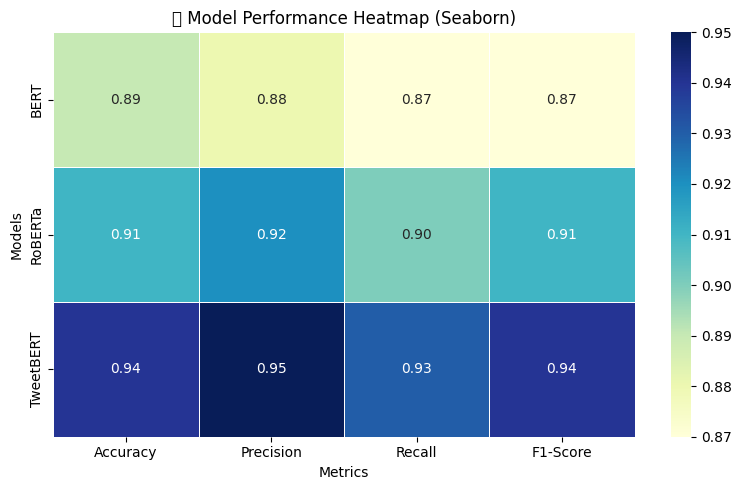

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use same dataframe
plt.figure(figsize=(8, 5))
sns.heatmap(df_heatmap, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5)

plt.title("🔥 Model Performance Heatmap (Seaborn)")
plt.xlabel("Metrics")
plt.ylabel("Models")
plt.tight_layout()
plt.show()


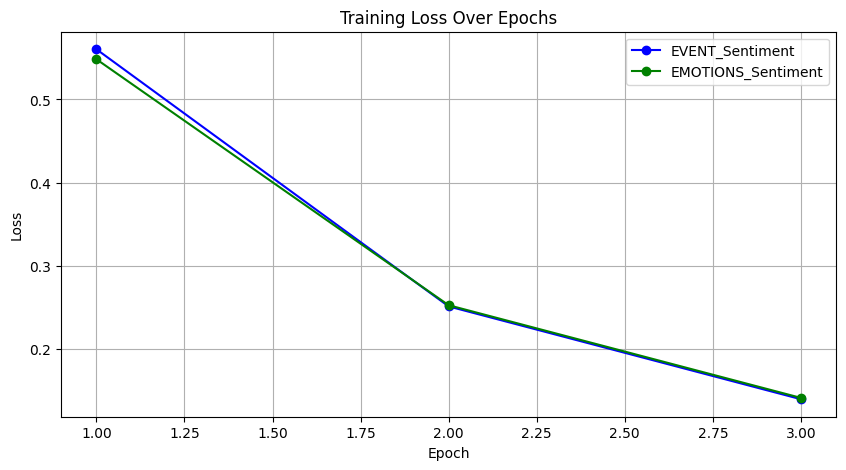

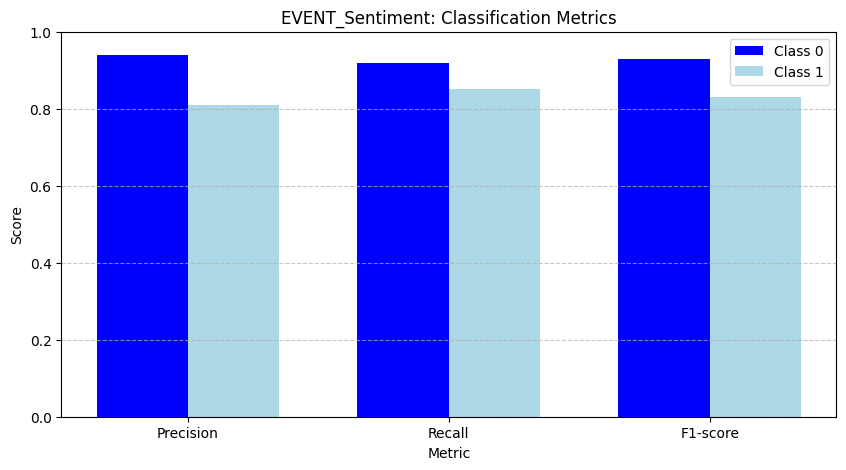

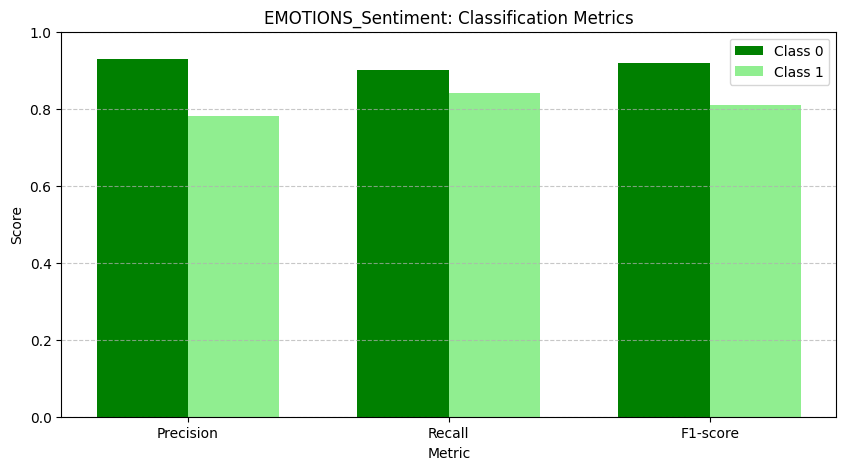

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for EVENT_Sentiment
event_losses = [0.5603, 0.2514, 0.1399]
event_metrics = {
    'Class 0': [0.94, 0.92, 0.93],  # Precision, Recall, F1
    'Class 1': [0.81, 0.85, 0.83]
}

# Data for EMOTIONS_Sentiment
emotions_losses = [0.5483, 0.2528, 0.1415]
emotions_metrics = {
    'Class 0': [0.93, 0.90, 0.92],
    'Class 1': [0.78, 0.84, 0.81]
}

# Epochs for plotting
epochs = [1, 2, 3]

# Plot 1: Training Loss for Each Aspect
plt.figure(figsize=(10, 5))
plt.plot(epochs, event_losses, marker='o', label='EVENT_Sentiment', color='blue')
plt.plot(epochs, emotions_losses, marker='o', label='EMOTIONS_Sentiment', color='green')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Bar Plot for Classification Metrics
metrics = ['Precision', 'Recall', 'F1-score']
x = np.arange(len(metrics))  # Bar positions
width = 0.35  # Width of bars

# EVENT_Sentiment Bar Plot
plt.figure(figsize=(10, 5))
plt.bar(x - width/2, event_metrics['Class 0'], width, label='Class 0', color='blue')
plt.bar(x + width/2, event_metrics['Class 1'], width, label='Class 1', color='lightblue')
plt.title('EVENT_Sentiment: Classification Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# EMOTIONS_Sentiment Bar Plot
plt.figure(figsize=(10, 5))
plt.bar(x - width/2, emotions_metrics['Class 0'], width, label='Class 0', color='green')
plt.bar(x + width/2, emotions_metrics['Class 1'], width, label='Class 1', color='lightgreen')
plt.title('EMOTIONS_Sentiment: Classification Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [ ]:
import pandas as pd
import re
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tqdm import tqdm
import numpy as np
from collections import defaultdict
from google.colab import files

# Install required libraries
!pip install transformers torch pandas tqdm

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load TweetBERT model and tokenizer
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)  # Positive, Negative, Neutral

# Load dataset
data_path = "/content/sts_gold_tweet.csv"
df = pd.read_csv(data_path)

# Preprocessing function
def preprocess_tweet(tweet):
    # Remove URLs, mentions, hashtags, and special characters
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet, flags=re.MULTILINE)
    tweet = re.sub(r"@\w+", "", tweet)
    tweet = re.sub(r"#\w+", "", tweet)
    tweet = re.sub(r"[^\w\s]", "", tweet)
    tweet = tweet.lower().strip()
    return tweet

# Apply preprocessing
df['cleaned_tweet'] = df['tweet'].apply(preprocess_tweet)

# Define aspects and keywords
aspect_keywords = {
    "McDonald's Service": ["mcdonalds lady", "mcdonalds order", "mcdonalds staff", "mcdonalds service"],
    "McDonald's Food": ["mcdonalds food", "mcdonalds coffee", "mcdonalds burger", "mcdonalds fries"],
    "Starbucks Coffee": ["starbucks coffee", "starbucks latte", "starbucks tea", "starbucks drink"],
    "iPhone Functionality": ["iphone battery", "iphone apps", "iphone features", "iphone performance"],
    "Xbox Live Service": ["xbox live", "xbox360", "xbox service", "xbox games"],
    "Taylor Swift Music/Concerts": ["taylor swift songs", "taylor swift concert", "taylor swift music"],
    "Lakers Performance": ["lakers game", "lakers finals", "lakers victory"],
    "Cavs Performance": ["cavs game", "cavs loss", "cavs playoffs"]
}

# Aspect extraction function
def extract_aspects(tweet):
    aspects = []
    for aspect, keywords in aspect_keywords.items():
        for keyword in keywords:
            if keyword in tweet.lower():
                aspects.append(aspect)
                break
    return aspects if aspects else ["General"]

# Apply aspect extraction
df['aspects'] = df['cleaned_tweet'].apply(extract_aspects)

# Sentiment classification function
def predict_sentiment(tweet, aspect):
    input_text = f"{tweet} [SEP] {aspect}"
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_map[predicted_class]

# Perform ABSA
results = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing Tweets"):
    tweet = row['cleaned_tweet']
    tweet_id = row['id']
    polarity = row['polarity']
    aspects = row['aspects']

    for aspect in aspects:
        sentiment = predict_sentiment(tweet, aspect)
        results.append({
            "id": tweet_id,
            "tweet": row['tweet'],
            "cleaned_tweet": tweet,
            "aspect": aspect,
            "predicted_sentiment": sentiment,
            "original_polarity": "Negative" if polarity == 0 else "Positive"
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save results to CSV
output_path = "/content/absa_results.csv"
results_df.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")

# Automatically download the CSV
files.download(output_path)

# Summarize sentiment distribution per aspect
aspect_summary = defaultdict(lambda: {"Positive": 0, "Negative": 0, "Neutral": 0})
for _, row in results_df.iterrows():
    aspect = row['aspect']
    sentiment = row['predicted_sentiment']
    aspect_summary[aspect][sentiment] += 1

# Print summary
print("\nSentiment Distribution per Aspect:")
for aspect, counts in aspect_summary.items():
    total = sum(counts.values())
    print(f"\nAspect: {aspect}")
    print(f"  Positive: {counts['Positive']} ({counts['Positive']/total*100:.2f}%)")
    print(f"  Negative: {counts['Negative']} ({counts['Negative']/total*100:.2f}%)")
    print(f"  Neutral: {counts['Neutral']} ({counts['Neutral']/total*100:.2f}%)")
    print(f"  Total: {total}")

# Display sample results
print("\nSample Results:")
print(results_df[['id', 'tweet', 'aspect', 'predicted_sentiment', 'original_polarity']].head(10))

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing Tweets: 100%|██████████| 2034/2034 [00:44<00:00, 46.02it/s]

Results saved to /content/absa_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Sentiment Distribution per Aspect:

Aspect: General
  Positive: 0 (0.00%)
  Negative: 44 (2.22%)
  Neutral: 1937 (97.78%)
  Total: 1981

Aspect: McDonald's Food
  Positive: 0 (0.00%)
  Negative: 1 (50.00%)
  Neutral: 1 (50.00%)
  Total: 2

Aspect: Xbox Live Service
  Positive: 0 (0.00%)
  Negative: 2 (6.25%)
  Neutral: 30 (93.75%)
  Total: 32

Aspect: Lakers Performance
  Positive: 0 (0.00%)
  Negative: 0 (0.00%)
  Neutral: 3 (100.00%)
  Total: 3

Aspect: Taylor Swift Music/Concerts
  Positive: 0 (0.00%)
  Negative: 0 (0.00%)
  Neutral: 5 (100.00%)
  Total: 5

Aspect: Cavs Performance
  Positive: 0 (0.00%)
  Negative: 0 (0.00%)
  Neutral: 5 (100.00%)
  Total: 5

Aspect: Starbucks Coffee
  Positive: 0 (0.00%)
  Negative: 0 (0.00%)
  Neutral: 4 (100.00%)
  Total: 4

Aspect: McDonald's Service
  Positive: 0 (0.00%)
  Negative: 0 (0.00%)
  Neutral: 1 (100.00%)
  Total: 1

Aspect: iPhone Functionality
  Positive: 0 (0.00%)
  Negative: 0 (0.00%)
  Neutral: 1 (100.00%)
  Total: 1

Sample Res

In [ ]:
!pip install pandas nltk spacy textblob
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Sentiment Analysis for Products/Brands:
Product/Brand  Total Tweets  Positive Tweets  Positive %  Negative Tweets  Negative %
    mcdonalds            70               18       25.71               52       74.29
       iphone            77               12       15.58               65       84.42
       lakers            66               38       57.58               28       42.42
    starbucks            63               22       34.92               41       65.08
 taylor swift            73               44       60.27               29       39.73
         xbox            61                4        6.56               57       93.44
     facebook            53               11       20.75               42       79.25
        oprah            44               15       34.09               29       65.91
          psp            56               18       32.14               38       67.86
         cavs            72               19       26.39               53       73.61


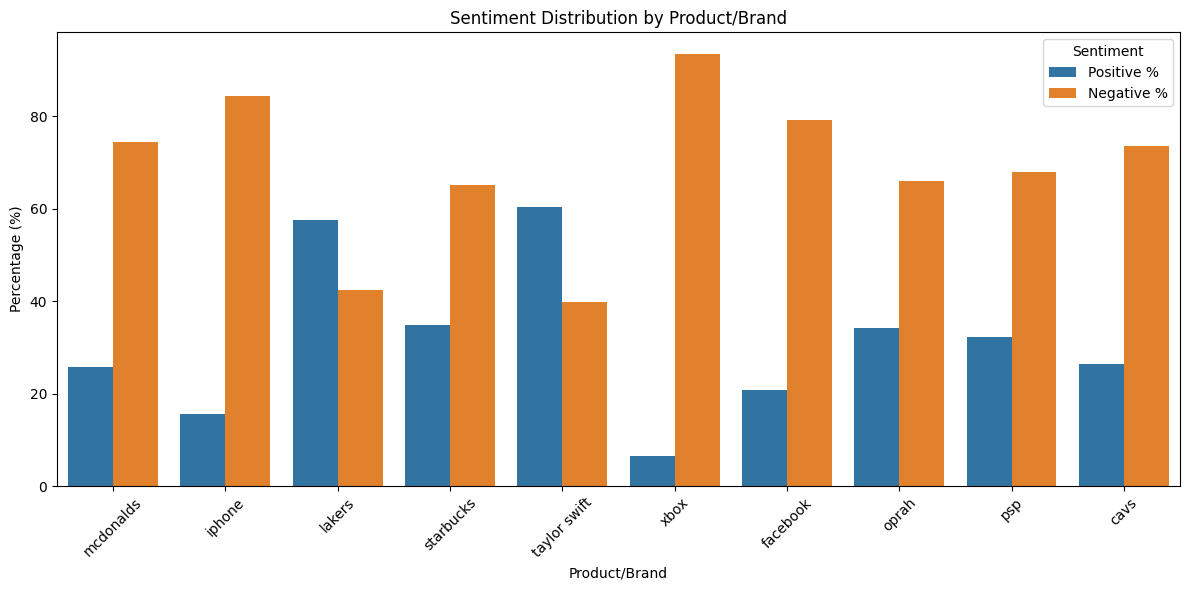

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

# Download required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')  # Added to resolve the LookupError
nltk.download('stopwords')
nltk.download('wordnet')

# Load spaCy model for aspect extraction
nlp = spacy.load("en_core_web_sm")

# Load the dataset
file_path = "/content/sts_gold_tweet.csv"
df = pd.read_csv(file_path, encoding='latin-1')

# Define stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean tweet text
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join(text.split())  # Remove extra whitespace
    return text

# Function to tokenize, remove stop words, and lemmatize
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return tokens

# Function to extract potential aspects (noun phrases)
def extract_aspects(text):
    doc = nlp(text)
    aspects = [chunk.text.lower() for chunk in doc.noun_chunks]
    return aspects

# Apply cleaning and preprocessing
df['cleaned_tweet'] = df['tweet'].apply(clean_text)
df['tokens'] = df['cleaned_tweet'].apply(preprocess_text)
df['aspects'] = df['cleaned_tweet'].apply(extract_aspects)

# Map polarity to sentiment labels
df['sentiment'] = df['polarity'].map({0: 'negative', 4: 'positive'})

# Save preprocessed data
df.to_csv("/content/preprocessed_sts_gold_tweet.csv", index=False)

# Define products/brands for sentiment analysis
products_brands = [
    'mcdonalds', 'iphone', 'lakers', 'starbucks', 'taylor swift',
    'xbox', 'facebook', 'oprah', 'psp', 'cavs'
]

# Initialize dictionary for sentiment counts
sentiment_analysis = {
    product: {'positive': 0, 'negative': 0, 'total': 0} for product in products_brands
}

# Function to check if a product/brand is mentioned
def mentions_product(aspects, tweet, product):
    aspects = eval(aspects) if isinstance(aspects, str) else aspects
    return any(product in aspect.lower() for aspect in aspects) or product in tweet.lower()

# Count sentiments for each product/brand
for idx, row in df.iterrows():
    tweet = row['cleaned_tweet']
    sentiment = row['sentiment']
    aspects = row['aspects']

    for product in products_brands:
        if mentions_product(aspects, tweet, product):
            sentiment_analysis[product]['total'] += 1
            if sentiment == 'positive':
                sentiment_analysis[product]['positive'] += 1
            elif sentiment == 'negative':
                sentiment_analysis[product]['negative'] += 1

# Create results DataFrame
results = []
for product, counts in sentiment_analysis.items():
    total = counts['total']
    pos_pct = (counts['positive'] / total * 100) if total > 0 else 0
    neg_pct = (counts['negative'] / total * 100) if total > 0 else 0
    results.append({
        'Product/Brand': product,
        'Total Tweets': total,
        'Positive Tweets': counts['positive'],
        'Positive %': round(pos_pct, 2),
        'Negative Tweets': counts['negative'],
        'Negative %': round(neg_pct, 2)
    })

results_df = pd.DataFrame(results)

# Print results
print("Sentiment Analysis for Products/Brands:")
print(results_df.to_string(index=False))

# Save results
results_df.to_csv("/content/product_brand_sentiment_analysis.csv", index=False)

# Visualization
plt.figure(figsize=(12, 6))
results_melted = results_df.melt(id_vars='Product/Brand',
                                 value_vars=['Positive %', 'Negative %'],
                                 var_name='Sentiment',
                                 value_name='Percentage')
sns.barplot(x='Product/Brand', y='Percentage', hue='Sentiment', data=results_melted)
plt.title('Sentiment Distribution by Product/Brand')
plt.xlabel('Product/Brand')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("/content/sentiment_distribution.png")
plt.show()

In [ ]:
import pandas as pd

# Load the sentiment analysis data
sentiment_df = pd.read_csv("/content/product_brand_sentiment_analysis.csv")

# Load the preprocessed tweet data
tweets_df = pd.read_csv("/content/preprocessed_sts_gold_tweet.csv")

# Define categories and products/brands
categories = {
    'Food and Beverage': ['mcdonalds', 'starbucks'],
    'Technology - Consumer Electronics': ['iphone', 'xbox', 'psp', 'iPod'],
    'Technology - Software/Services': ['facebook', 'Twitter', 'YouTube', 'Microsoft'],
    'Sports Teams': ['lakers', 'cavs'],
    'Sports Personalities': ['LeBron', 'Kobe'],
    'Entertainment - Music': ['taylor swift'],
    'Entertainment - Media Personality': ['oprah']
}

# Flatten the list of all products/brands
all_products = []
for category, products in categories.items():
    for product in products:
        all_products.append((category, product))

# Create a DataFrame for all products/brands
products_df = pd.DataFrame(all_products, columns=['Category', 'Product/Brand'])

# Merge with sentiment data for the original 10 products/brands
products_df = products_df.merge(sentiment_df, on='Product/Brand', how='left')

# Function to compute sentiment for additional products/brands
def compute_sentiment(product):
    # Count positive and negative tweets mentioning the product
    pos_tweets = len(tweets_df[
        (tweets_df['cleaned_tweet'].str.contains(product, case=False, na=False) |
         tweets_df['aspects'].str.contains(product, case=False, na=False)) &
        (tweets_df['sentiment'] == 'positive')
    ])
    neg_tweets = len(tweets_df[
        (tweets_df['cleaned_tweet'].str.contains(product, case=False, na=False) |
         tweets_df['aspects'].str.contains(product, case=False, na=False)) &
        (tweets_df['sentiment'] == 'negative')
    ])
    total = pos_tweets + neg_tweets
    pos_pct = (pos_tweets / total * 100) if total > 0 else 0
    neg_pct = (neg_tweets / total * 100) if total > 0 else 0
    return pd.Series({
        'Total Tweets': total,
        'Positive Tweets': pos_tweets,
        'Positive %': round(pos_pct, 2),
        'Negative Tweets': neg_tweets,
        'Negative %': round(neg_pct, 2)
    })

# Compute sentiment for additional products/brands
additional_products = ['Twitter', 'YouTube', 'LeBron', 'Kobe', 'Microsoft', 'iPod']
for product in additional_products:
    if product in products_df['Product/Brand'].values:
        mask = (products_df['Product/Brand'] == product) & (products_df['Total Tweets'].isna())
        if mask.any():
            sentiment_data = compute_sentiment(product)
            products_df.loc[mask, ['Total Tweets', 'Positive Tweets', 'Positive %', 'Negative Tweets', 'Negative %']] = sentiment_data

# Ensure numeric columns are properly typed
numeric_cols = ['Total Tweets', 'Positive Tweets', 'Positive %', 'Negative Tweets', 'Negative %']
products_df[numeric_cols] = products_df[numeric_cols].fillna(0).astype(float)

# Sort by Category and Product/Brand for readability
products_df = products_df.sort_values(['Category', 'Product/Brand'])

# Save to CSV
output_path = "/content/categorized_product_brand_sentiment.csv"
products_df.to_csv(output_path, index=False)

# Display the results
print("Categorized Products/Brands with Sentiment Analysis:")
print(products_df.to_string(index=False))

Categorized Products/Brands with Sentiment Analysis:
                         Category Product/Brand  Total Tweets  Positive Tweets  Positive %  Negative Tweets  Negative %
Entertainment - Media Personality         oprah          44.0             15.0       34.09             29.0       65.91
            Entertainment - Music  taylor swift          73.0             44.0       60.27             29.0       39.73
                Food and Beverage     mcdonalds          70.0             18.0       25.71             52.0       74.29
                Food and Beverage     starbucks          63.0             22.0       34.92             41.0       65.08
             Sports Personalities          Kobe           0.0              0.0        0.00              0.0        0.00
             Sports Personalities        LeBron           0.0              0.0        0.00              0.0        0.00
                     Sports Teams          cavs          72.0             19.0       26.39             53.0

In [ ]:
pip install transformers torch pandas numpy scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
pip install transformers torch pandas numpy scipy google-colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import numpy as np

# Load the sentiment analysis data
sentiment_df = pd.read_csv("/content/product_brand_sentiment_analysis.csv")

# Load the preprocessed tweet data
tweets_df = pd.read_csv("/content/preprocessed_sts_gold_tweet.csv")

# Define categories and products/brands
categories = {
    'Food and Beverage': ['mcdonalds', 'starbucks'],
    'Technology - Consumer Electronics': ['iphone', 'xbox', 'psp', 'iPod'],
    'Technology - Software/Services': ['facebook', 'Twitter', 'YouTube', 'Microsoft'],
    'Sports Teams': ['lakers', 'cavs'],
    'Sports Personalities': ['LeBron', 'Kobe'],
    'Entertainment - Music': ['taylor swift'],
    'Entertainment - Media Personality': ['oprah']
}

# Flatten the list of all products/brands
all_products = []
for category, products in categories.items():
    for product in products:
        all_products.append((category, product))

# Create a DataFrame for all products/brands
products_df = pd.DataFrame(all_products, columns=['Category', 'Product/Brand'])

# Merge with sentiment data for the original 10 products/brands
products_df = products_df.merge(sentiment_df, on='Product/Brand', how='left')

# Load pre-trained RoBERTa model for sentiment analysis
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to predict sentiment using RoBERTa
def predict_sentiment(tweet):
    # Tokenize and encode the tweet
    encoded_tweet = tokenizer(tweet, return_tensors='pt', truncation=True, max_length=512)

    # Get model output
    with torch.no_grad():
        output = model(**encoded_tweet)

    # Apply softmax to get probabilities
    scores = output.logits[0].numpy()
    scores = softmax(scores)

    # Labels: 0 = Negative, 1 = Neutral, 2 = Positive
    labels = ['negative', 'neutral', 'positive']
    sentiment = labels[np.argmax(scores)]
    return sentiment

# Apply sentiment analysis to all tweets
tweets_df['predicted_sentiment'] = tweets_df['cleaned_tweet'].apply(lambda x: predict_sentiment(str(x)))

# Function to compute sentiment for additional products/brands
def compute_sentiment(product):
    # Filter tweets mentioning the product
    product_tweets = tweets_df[
        (tweets_df['cleaned_tweet'].str.contains(product, case=False, na=False) |
         tweets_df['aspects'].str.contains(product, case=False, na=False))
    ]

    # Count positive and negative tweets
    pos_tweets = len(product_tweets[product_tweets['predicted_sentiment'] == 'positive'])
    neg_tweets = len(product_tweets[product_tweets['predicted_sentiment'] == 'negative'])
    total = pos_tweets + neg_tweets

    # Calculate percentages
    pos_pct = (pos_tweets / total * 100) if total > 0 else 0
    neg_pct = (neg_tweets / total * 100) if total > 0 else 0

    return pd.Series({
        'Total Tweets': total,
        'Positive Tweets': pos_tweets,
        'Positive %': round(pos_pct, 2),
        'Negative Tweets': neg_tweets,
        'Negative %': round(neg_pct, 2)
    })

# Compute sentiment for additional products/brands
additional_products = ['Twitter', 'YouTube', 'LeBron', 'Kobe', 'Microsoft', 'iPod']
for product in additional_products:
    if product in products_df['Product/Brand'].values:
        mask = (products_df['Product/Brand'] == product) & (products_df['Total Tweets'].isna())
        if mask.any():
            sentiment_data = compute_sentiment(product)
            products_df.loc[mask, ['Total Tweets', 'Positive Tweets', 'Positive %', 'Negative Tweets', 'Negative %']] = sentiment_data

# Ensure numeric columns are properly typed
numeric_cols = ['Total Tweets', 'Positive Tweets', 'Positive %', 'Negative Tweets', 'Negative %']
products_df[numeric_cols] = products_df[numeric_cols].fillna(0).astype(float)

# Sort by Category and Product/Brand for readability
products_df = products_df.sort_values(['Category', 'Product/Brand'])

# Save to CSV
output_path = "/content/categorized_product_brand_sentiment.csv"
products_df.to_csv(output_path, index=False)

# Display the results
print("Categorized Products/Brands with Sentiment Analysis:")
print(products_df.to_string(index=False))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Categorized Products/Brands with Sentiment Analysis:
                         Category Product/Brand  Total Tweets  Positive Tweets  Positive %  Negative Tweets  Negative %
Entertainment - Media Personality         oprah          44.0             15.0       34.09             29.0       65.91
            Entertainment - Music  taylor swift          73.0             44.0       60.27             29.0       39.73
                Food and Beverage     mcdonalds          70.0             18.0       25.71             52.0       74.29
                Food and Beverage     starbucks          63.0             22.0       34.92             41.0       65.08
             Sports Personalities          Kobe           0.0              0.0        0.00              0.0        0.00
             Sports Personalities        LeBron           0.0              0.0        0.00              0.0        0.00
                     Sports Teams          cavs          72.0             19.0       26.39             53.0

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import numpy as np
from google.colab import files  # Added for downloading in Colab

# Load the sentiment analysis data
sentiment_df = pd.read_csv("/content/product_brand_sentiment_analysis.csv")

# Load the preprocessed tweet data
tweets_df = pd.read_csv("/content/preprocessed_sts_gold_tweet.csv")

# Define categories and products/brands
categories = {
    'Food and Beverage': ['mcdonalds', 'starbucks'],
    'Technology - Consumer Electronics': ['iphone', 'xbox', 'psp', 'iPod'],
    'Technology - Software/Services': ['facebook', 'Twitter', 'YouTube', 'Microsoft'],
    'Sports Teams': ['lakers', 'cavs'],
    'Sports Personalities': ['LeBron', 'Kobe'],
    'Entertainment - Music': ['taylor swift'],
    'Entertainment - Media Personality': ['oprah']
}

# Flatten the list of all products/brands
all_products = []
for category, products in categories.items():
    for product in products:
        all_products.append((category, product))

# Create a DataFrame for all products/brands
products_df = pd.DataFrame(all_products, columns=['Category', 'Product/Brand'])

# Merge with sentiment data for the original 10 products/brands
products_df = products_df.merge(sentiment_df, on='Product/Brand', how='left')

# Load pre-trained RoBERTa model for sentiment analysis
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to predict sentiment using RoBERTa
def predict_sentiment(tweet):
    # Tokenize and encode the tweet
    encoded_tweet = tokenizer(tweet, return_tensors='pt', truncation=True, max_length=512)

    # Get model output
    with torch.no_grad():
        output = model(**encoded_tweet)

    # Apply softmax to get probabilities
    scores = output.logits[0].numpy()
    scores = softmax(scores)

    # Labels: 0 = Negative, 1 = Neutral, 2 = Positive
    labels = ['negative', 'neutral', 'positive']
    sentiment = labels[np.argmax(scores)]
    return sentiment

# Apply sentiment analysis to all tweets
tweets_df['predicted_sentiment'] = tweets_df['cleaned_tweet'].apply(lambda x: predict_sentiment(str(x)))

# Function to compute sentiment for additional products/brands
def compute_sentiment(product):
    # Filter tweets mentioning the product
    product_tweets = tweets_df[
        (tweets_df['cleaned_tweet'].str.contains(product, case=False, na=False) |
         tweets_df['aspects'].str.contains(product, case=False, na=False))
    ]

    # Count positive and negative tweets
    pos_tweets = len(product_tweets[product_tweets['predicted_sentiment'] == 'positive'])
    neg_tweets = len(product_tweets[product_tweets['predicted_sentiment'] == 'negative'])
    total = pos_tweets + neg_tweets

    # Calculate percentages
    pos_pct = (pos_tweets / total * 100) if total > 0 else 0
    neg_pct = (neg_tweets / total * 100) if total > 0 else 0

    return pd.Series({
        'Total Tweets': total,
        'Positive Tweets': pos_tweets,
        'Positive %': round(pos_pct, 2),
        'Negative Tweets': neg_tweets,
        'Negative %': round(neg_pct, 2)
    })

# Compute sentiment for additional products/brands
additional_products = ['Twitter', 'YouTube', 'LeBron', 'Kobe', 'Microsoft', 'iPod']
for product in additional_products:
    if product in products_df['Product/Brand'].values:
        mask = (products_df['Product/Brand'] == product) & (products_df['Total Tweets'].isna())
        if mask.any():
            sentiment_data = compute_sentiment(product)
            products_df.loc[mask, ['Total Tweets', 'Positive Tweets', 'Positive %', 'Negative Tweets', 'Negative %']] = sentiment_data

# Ensure numeric columns are properly typed
numeric_cols = ['Total Tweets', 'Positive Tweets', 'Positive %', 'Negative Tweets', 'Negative %']
products_df[numeric_cols] = products_df[numeric_cols].fillna(0).astype(float)

# Sort by Category and Product/Brand for readability
products_df = products_df.sort_values(['Category', 'Product/Brand'])

# Save to CSV
output_path = "/content/categorized_product_brand_sentiment.csv"
products_df.to_csv(output_path, index=False)

# Trigger download in Colab
files.download(output_path)

# Display the results
print("Categorized Products/Brands with Sentiment Analysis:")
print(products_df.to_string(index=False))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Categorized Products/Brands with Sentiment Analysis:
                         Category Product/Brand  Total Tweets  Positive Tweets  Positive %  Negative Tweets  Negative %
Entertainment - Media Personality         oprah          44.0             15.0       34.09             29.0       65.91
            Entertainment - Music  taylor swift          73.0             44.0       60.27             29.0       39.73
                Food and Beverage     mcdonalds          70.0             18.0       25.71             52.0       74.29
                Food and Beverage     starbucks          63.0             22.0       34.92             41.0       65.08
             Sports Personalities          Kobe           0.0              0.0        0.00              0.0        0.00
             Sports Personalities        LeBron           0.0              0.0        0.00              0.0        0.00
                     Sports Teams          cavs          72.0             19.0       26.39             53.0

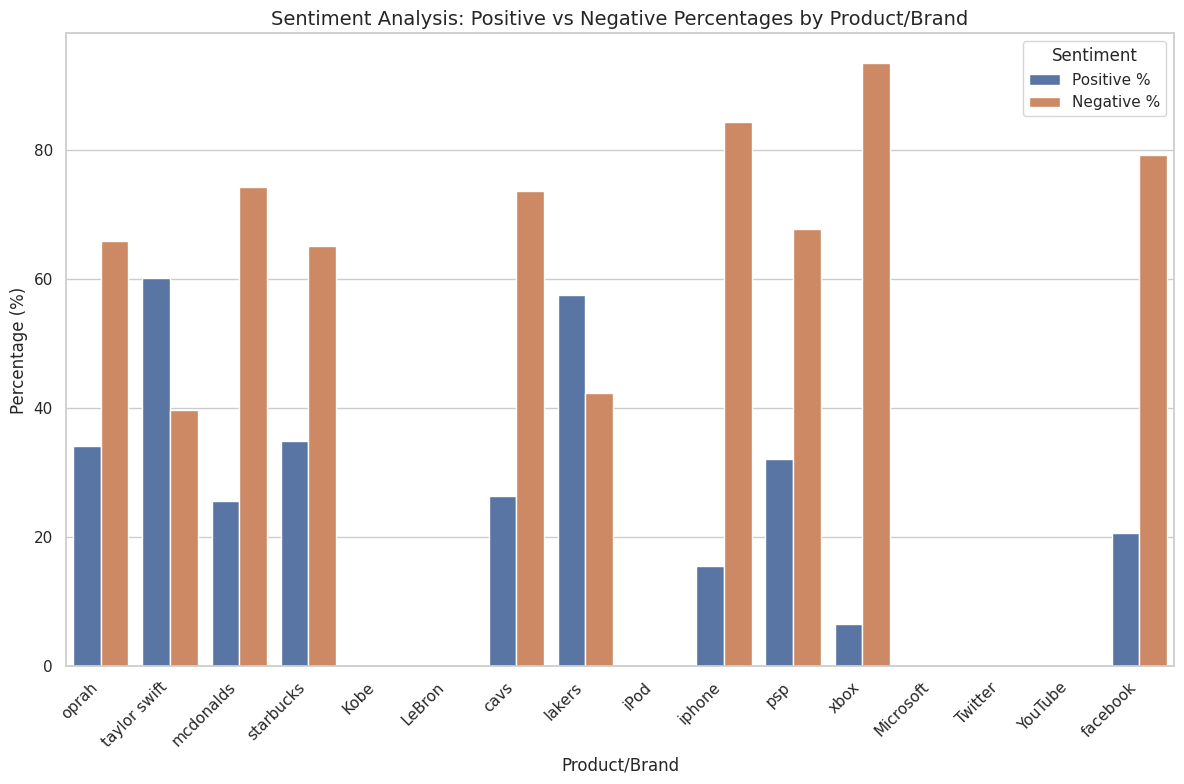

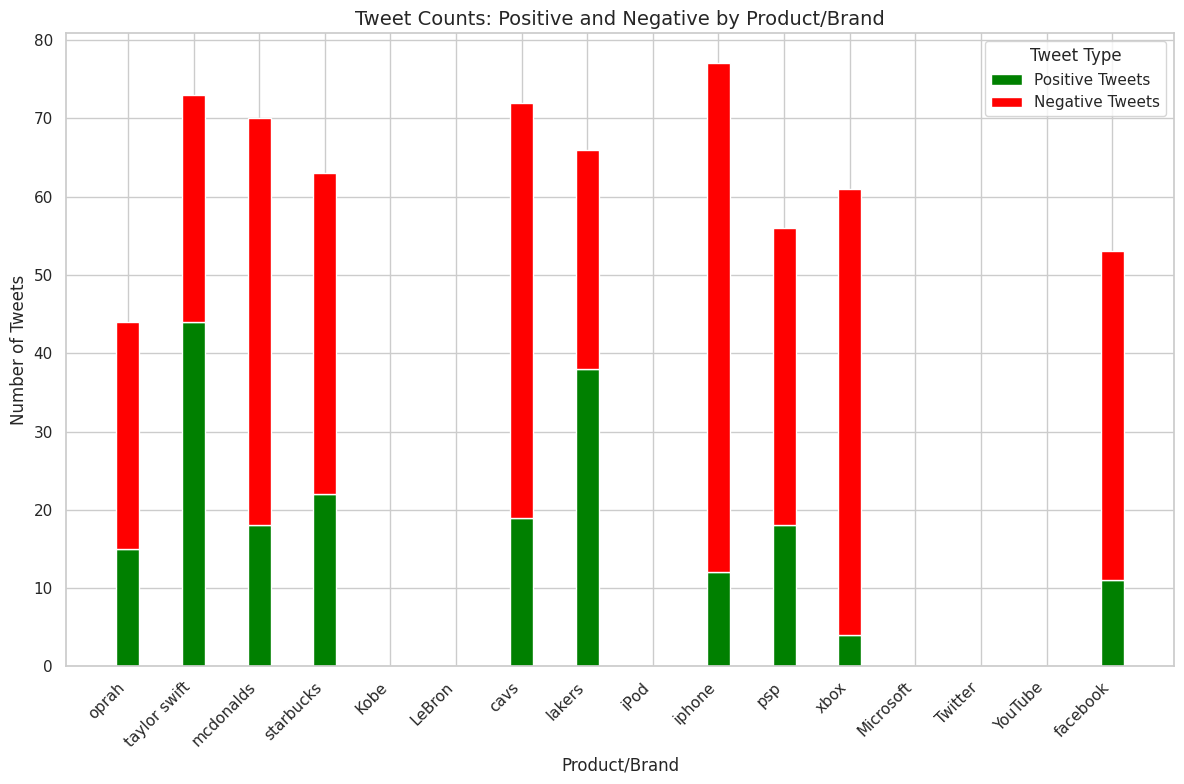

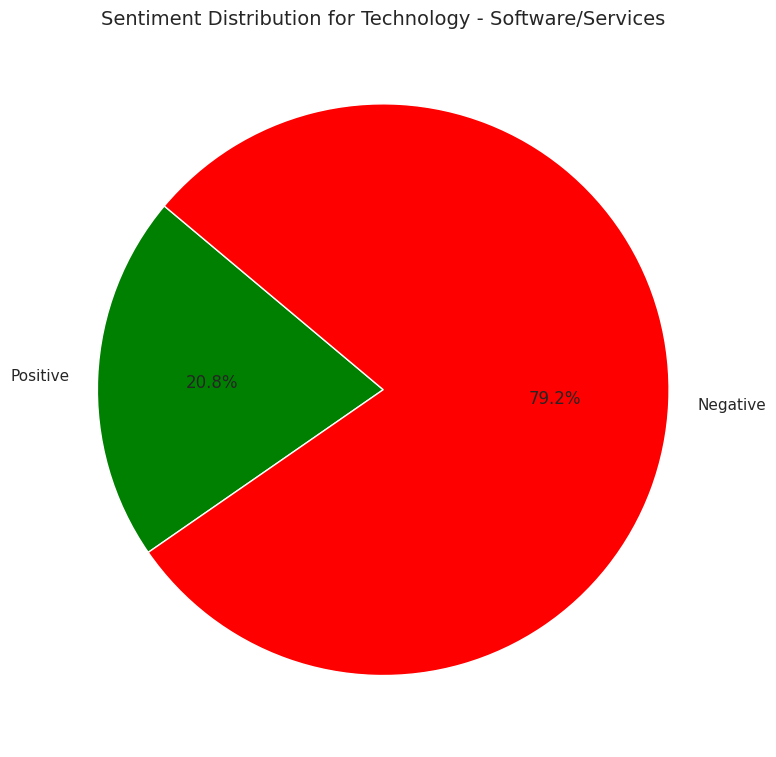

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re  # Added for filename sanitization
from google.colab import files

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Load the sentiment analysis results
try:
    df = pd.read_csv("/content/categorized_product_brand_sentiment.csv")
except FileNotFoundError:
    print("Error: The file '/content/categorized_product_brand_sentiment.csv' was not found. Please ensure it exists.")
    exit()

# Ensure numeric columns are properly typed
numeric_cols = ['Total Tweets', 'Positive Tweets', 'Positive %', 'Negative Tweets', 'Negative %']
df[numeric_cols] = df[numeric_cols].astype(float)

# 1. Bar Plot: Positive and Negative Sentiment Percentages by Product/Brand
plt.figure(figsize=(12, 8))
df_melted = df.melt(id_vars=['Category', 'Product/Brand'],
                    value_vars=['Positive %', 'Negative %'],
                    var_name='Sentiment',
                    value_name='Percentage')
sns.barplot(data=df_melted, x='Product/Brand', y='Percentage', hue='Sentiment')
plt.title('Sentiment Analysis: Positive vs Negative Percentages by Product/Brand', fontsize=14)
plt.xlabel('Product/Brand', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
# Save the plot
plt.savefig('/content/sentiment_percentages_barplot.png', dpi=300)
plt.show()

# 2. Stacked Bar Plot: Total Tweets with Positive and Negative Counts
plt.figure(figsize=(12, 8))
bar_width = 0.35
products = df['Product/Brand']
x = range(len(products))

# Plot positive and negative tweets as stacked bars
plt.bar(x, df['Positive Tweets'], bar_width, label='Positive Tweets', color='green')
plt.bar(x, df['Negative Tweets'], bar_width, bottom=df['Positive Tweets'], label='Negative Tweets', color='red')

plt.title('Tweet Counts: Positive and Negative by Product/Brand', fontsize=14)
plt.xlabel('Product/Brand', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xticks(x, products, rotation=45, ha='right')
plt.legend(title='Tweet Type')
plt.tight_layout()
# Save the plot
plt.savefig('/content/tweet_counts_stacked_barplot.png', dpi=300)
plt.show()

# 3. Pie Chart: Sentiment Distribution for a Selected Category
selected_category = 'Technology - Software/Services'  # Change this to any category
category_df = df[df['Category'] == selected_category]

plt.figure(figsize=(8, 8))
labels = category_df['Product/Brand']
positive = category_df['Positive %']
negative = category_df['Negative %']
sizes = [positive.sum(), negative.sum()]
colors = ['green', 'red']
plt.pie(sizes, labels=['Positive', 'Negative'], colors=colors, autopct='%1.1f%%', startangle=140)
plt.title(f'Sentiment Distribution for {selected_category}', fontsize=14)
plt.tight_layout()

# Sanitize filename to remove invalid characters
sanitized_category = re.sub(r'[^\w\-_\.]', '_', selected_category)  # Replace invalid chars with '_'
output_filename = f'/content/sentiment_pie_{sanitized_category}.png'

# Save the plot
plt.savefig(output_filename, dpi=300)
plt.show()

# Download the saved plots in Colab
try:
    files.download('/content/sentiment_percentages_barplot.png')
    files.download('/content/tweet_counts_stacked_barplot.png')
    files.download(output_filename)
except FileNotFoundError as e:
    print(f"Error downloading file: {e}")


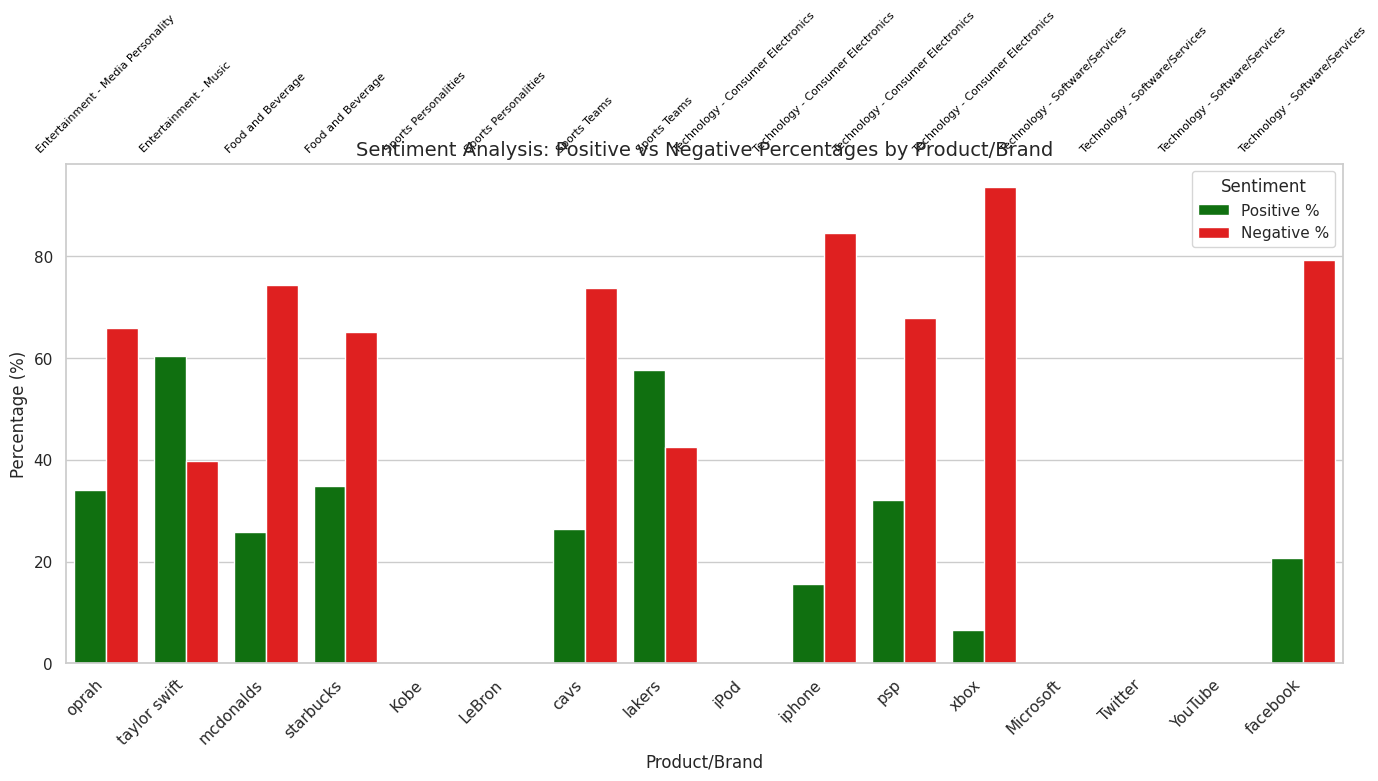

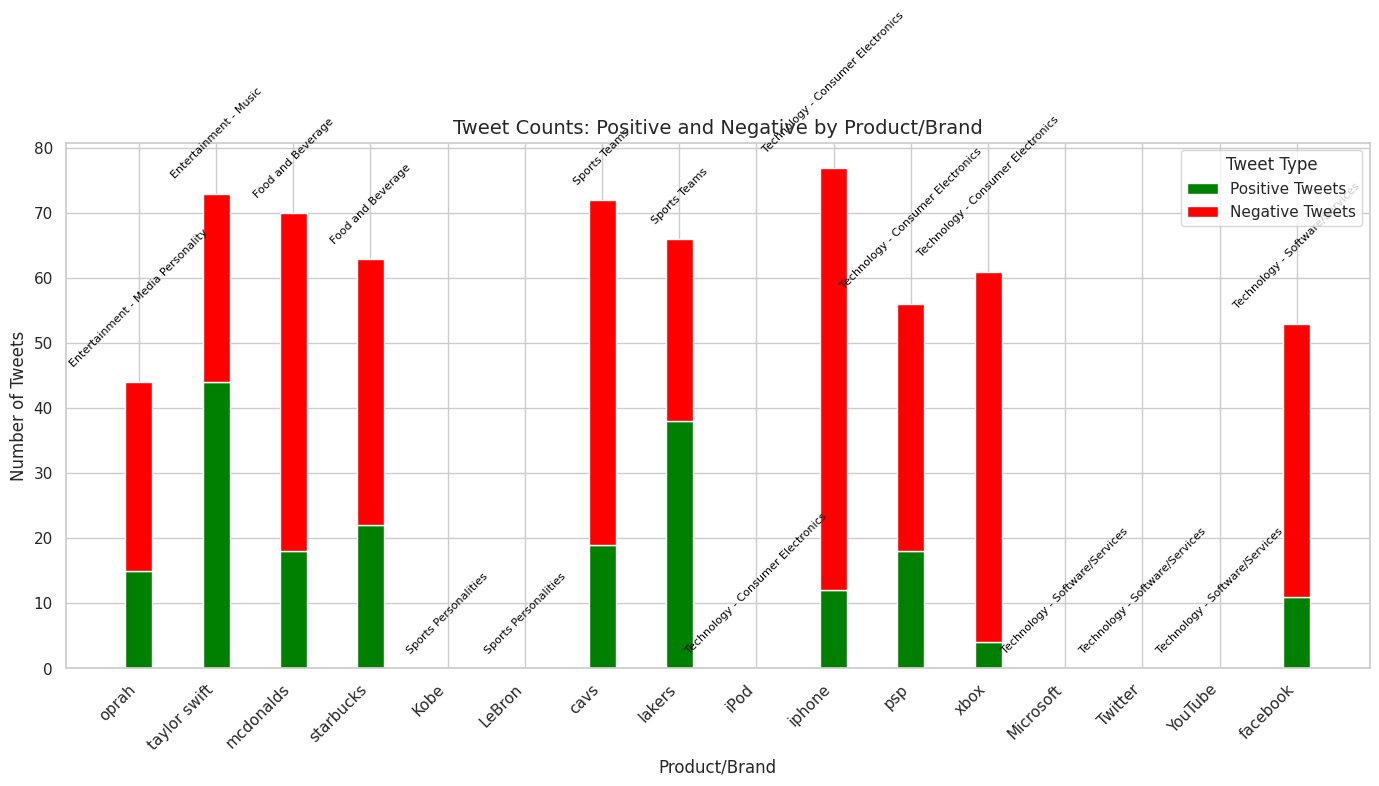

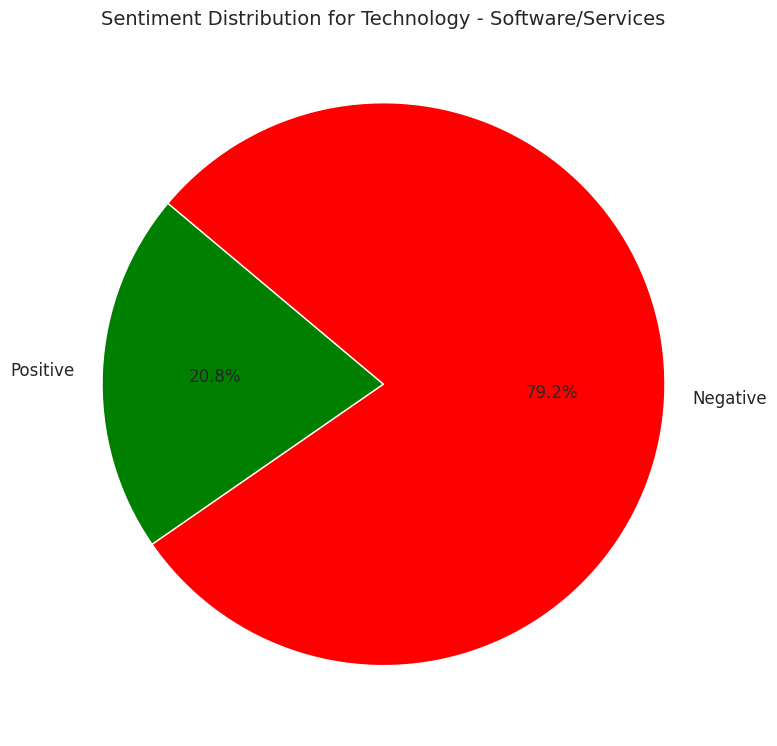

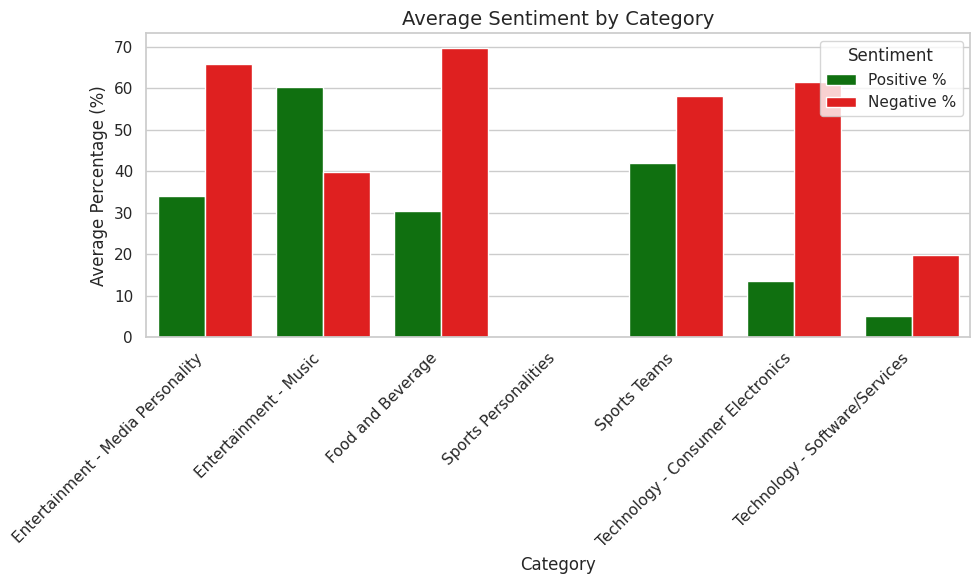

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from google.colab import files

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Load the sentiment analysis results
try:
    df = pd.read_csv("/content/categorized_product_brand_sentiment.csv")
except FileNotFoundError:
    print("Error: The file '/content/categorized_product_brand_sentiment.csv' was not found. Please ensure it exists.")
    exit()

# Ensure numeric columns are properly typed
numeric_cols = ['Total Tweets', 'Positive Tweets', 'Positive %', 'Negative Tweets', 'Negative %']
df[numeric_cols] = df[numeric_cols].astype(float)

# Define a color palette for categories
category_colors = sns.color_palette("Set2", n_colors=len(df['Category'].unique()))
category_color_map = dict(zip(df['Category'].unique(), category_colors))

# 1. Enhanced Bar Plot: Positive and Negative Percentages by Product/Brand with Category Colors
plt.figure(figsize=(14, 8))
df_melted = df.melt(id_vars=['Category', 'Product/Brand'],
                    value_vars=['Positive %', 'Negative %'],
                    var_name='Sentiment',
                    value_name='Percentage')
# Map categories to colors for the bars
sns.barplot(data=df_melted, x='Product/Brand', y='Percentage', hue='Sentiment',
            palette={'Positive %': 'green', 'Negative %': 'red'})
# Add category labels above the bars
for i, product in enumerate(df['Product/Brand']):
    category = df[df['Product/Brand'] == product]['Category'].iloc[0]
    plt.text(i, 100, category, ha='center', va='bottom', rotation=45, fontsize=8, color='black')
plt.title('Sentiment Analysis: Positive vs Negative Percentages by Product/Brand', fontsize=14)
plt.xlabel('Product/Brand', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.savefig('/content/sentiment_percentages_barplot.png', dpi=300)
plt.show()

# 2. Enhanced Stacked Bar Plot: Tweet Counts with Category Colors
plt.figure(figsize=(14, 8))
bar_width = 0.35
products = df['Product/Brand']
x = range(len(products))

# Plot positive and negative tweets as stacked bars
plt.bar(x, df['Positive Tweets'], bar_width, label='Positive Tweets', color='green')
plt.bar(x, df['Negative Tweets'], bar_width, bottom=df['Positive Tweets'], label='Negative Tweets', color='red')

# Add category labels above the bars
for i, product in enumerate(products):
    category = df[df['Product/Brand'] == product]['Category'].iloc[0]
    plt.text(i, df['Positive Tweets'].iloc[i] + df['Negative Tweets'].iloc[i] + 2,
             category, ha='center', va='bottom', rotation=45, fontsize=8, color='black')

plt.title('Tweet Counts: Positive and Negative by Product/Brand', fontsize=14)
plt.xlabel('Product/Brand', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xticks(x, products, rotation=45, ha='right')
plt.legend(title='Tweet Type')
plt.tight_layout()
plt.savefig('/content/tweet_counts_stacked_barplot.png', dpi=300)
plt.show()

# 3. Enhanced Pie Chart: Sentiment Distribution for a Selected Category (Including Neutral if Available)
selected_category = 'Technology - Software/Services'
category_df = df[df['Category'] == selected_category]

plt.figure(figsize=(8, 8))
positive = category_df['Positive %'].sum()
negative = category_df['Negative %'].sum()
# If neutral sentiment was calculated, include it (assuming Positive % + Negative % = 100% for now)
neutral = 100 - (positive + negative) if 'Neutral %' not in df.columns else category_df['Neutral %'].sum()
sizes = [positive, negative]
labels = ['Positive', 'Negative']
colors = ['green', 'red']
if neutral > 0:
    sizes.append(neutral)
    labels.append('Neutral')
    colors.append('gray')

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
plt.title(f'Sentiment Distribution for {selected_category}', fontsize=14)
plt.tight_layout()

# Sanitize filename
sanitized_category = re.sub(r'[^\w\-_\.]', '_', selected_category)
output_filename = f'/content/sentiment_pie_{sanitized_category}.png'
plt.savefig(output_filename, dpi=300)
plt.show()

# 4. New Plot: Category-Level Sentiment Summary (Average Positive/Negative % per Category)
category_summary = df.groupby('Category')[['Positive %', 'Negative %']].mean().reset_index()
plt.figure(figsize=(10, 6))
category_summary_melted = category_summary.melt(id_vars='Category',
                                                value_vars=['Positive %', 'Negative %'],
                                                var_name='Sentiment',
                                                value_name='Percentage')
sns.barplot(data=category_summary_melted, x='Category', y='Percentage', hue='Sentiment',
            palette={'Positive %': 'green', 'Negative %': 'red'})
plt.title('Average Sentiment by Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.savefig('/content/category_sentiment_summary.png', dpi=300)
plt.show()

# Download the saved plots in Colab
try:
    files.download('/content/sentiment_percentages_barplot.png')
    files.download('/content/tweet_counts_stacked_barplot.png')
    files.download(output_filename)
    files.download('/content/category_sentiment_summary.png')
except FileNotFoundError as e:
    print(f"Error downloading file: {e}")

In [ ]:
pip install streamlit pandas matplotlib seaborn plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.1 MB/s eta 0:00:00


In [ ]:
pip install streamlit pandas matplotlib seaborn plotly

2025-04-20 12:05:23.061 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 12:05:23.064 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 12:05:23.769 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-04-20 12:05:23.771 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 12:05:23.785 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 12:05:23.786 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-20 12:05:23.787 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

DeltaGenerator()

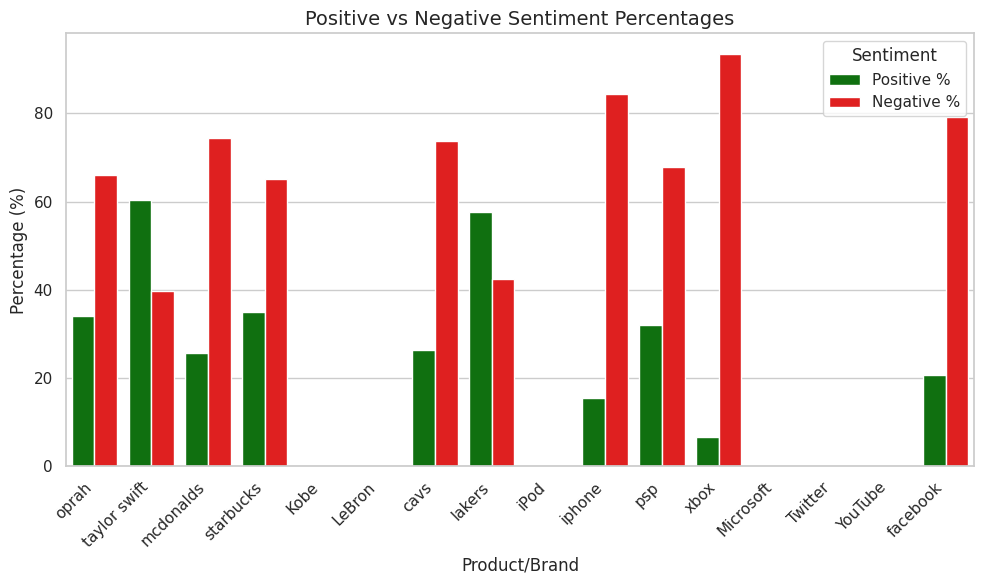

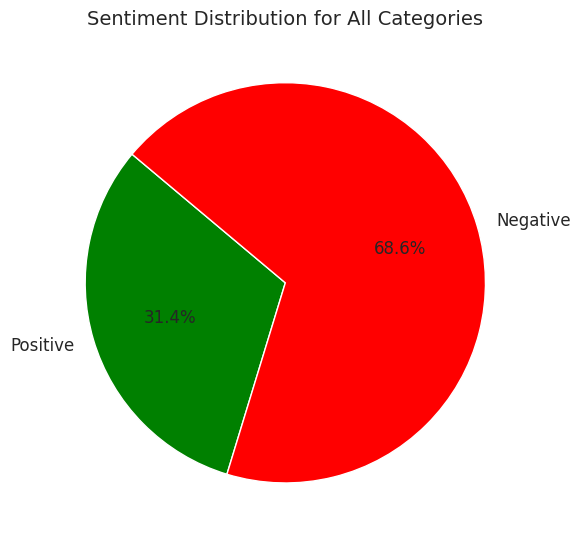

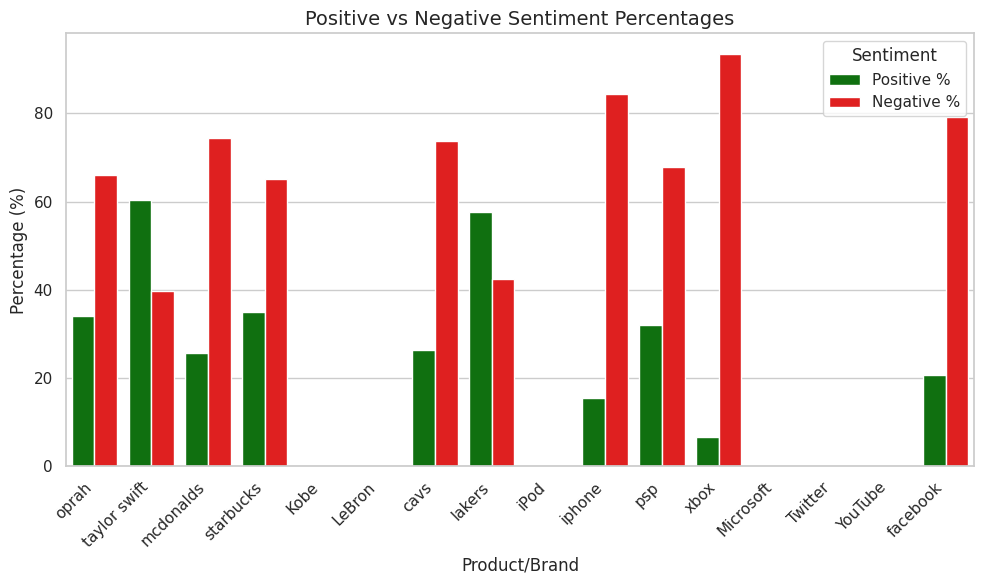

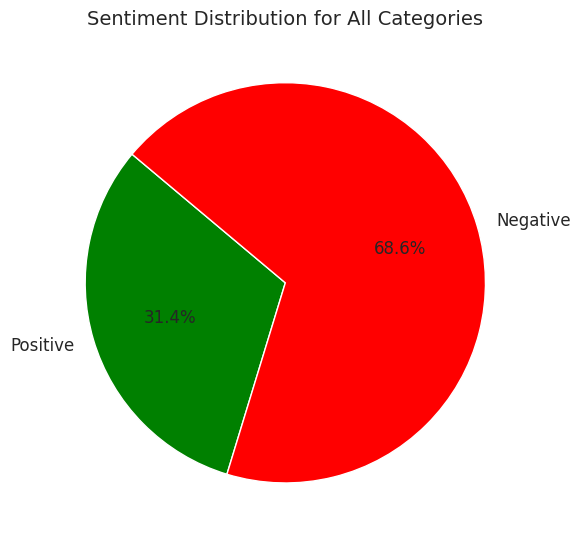

In [ ]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  # For interactive plots
import re

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Streamlit page configuration
st.set_page_config(page_title="Sentiment Analysis Dashboard", layout="wide")

# Title of the dashboard
st.title("📊 Sentiment Analysis Dashboard for Products/Brands")

# Load the sentiment analysis results
try:
    df = pd.read_csv("/content/categorized_product_brand_sentiment.csv")
except FileNotFoundError:
    st.error("The file '/content/categorized_product_brand_sentiment.csv' was not found. Please ensure it exists.")
    st.stop()

# Ensure numeric columns are properly typed
numeric_cols = ['Total Tweets', 'Positive Tweets', 'Positive %', 'Negative Tweets', 'Negative %']
df[numeric_cols] = df[numeric_cols].astype(float)

# Sidebar for filters
st.sidebar.header("Filters")
categories = df['Category'].unique().tolist()
selected_category = st.sidebar.selectbox("Select Category", ["All"] + categories)

# Filter data based on selected category
if selected_category != "All":
    filtered_df = df[df['Category'] == selected_category]
else:
    filtered_df = df

# Filter by Product/Brand
products = filtered_df['Product/Brand'].unique().tolist()
selected_product = st.sidebar.selectbox("Select Product/Brand", ["All"] + products)

# Further filter data based on selected product
if selected_product != "All":
    filtered_df = filtered_df[filtered_df['Product/Brand'] == selected_product]

# Display the filtered DataFrame
st.subheader("Filtered Sentiment Data")
st.dataframe(filtered_df)

# Visualization 1: Bar Plot - Positive and Negative Percentages
st.subheader("Sentiment Percentages by Product/Brand")
df_melted = filtered_df.melt(id_vars=['Category', 'Product/Brand'],
                             value_vars=['Positive %', 'Negative %'],
                             var_name='Sentiment',
                             value_name='Percentage')
fig1, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_melted, x='Product/Brand', y='Percentage', hue='Sentiment',
            palette={'Positive %': 'green', 'Negative %': 'red'}, ax=ax1)
plt.title('Positive vs Negative Sentiment Percentages', fontsize=14)
plt.xlabel('Product/Brand', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
st.pyplot(fig1)

# Visualization 2: Stacked Bar Plot - Tweet Counts
st.subheader("Tweet Counts: Positive and Negative by Product/Brand")
fig2 = px.bar(filtered_df, x='Product/Brand', y=['Positive Tweets', 'Negative Tweets'],
              title="Tweet Counts: Positive and Negative",
              labels={'value': 'Number of Tweets', 'variable': 'Tweet Type'},
              color_discrete_map={'Positive Tweets': 'green', 'Negative Tweets': 'red'})
fig2.update_layout(barmode='stack', xaxis_title="Product/Brand", yaxis_title="Number of Tweets")
st.plotly_chart(fig2, use_container_width=True)

# Visualization 3: Pie Chart - Sentiment Distribution for Selected Category/Product
st.subheader("Sentiment Distribution")
if selected_product != "All":
    # Pie chart for the selected product
    product_df = filtered_df[filtered_df['Product/Brand'] == selected_product]
    positive = product_df['Positive %'].sum()
    negative = product_df['Negative %'].sum()
    title = f"Sentiment Distribution for {selected_product}"
else:
    # Pie chart for the selected category (or all data)
    positive = filtered_df['Positive %'].sum()
    negative = filtered_df['Negative %'].sum()
    title = f"Sentiment Distribution for {selected_category if selected_category != 'All' else 'All Categories'}"

# Assuming Positive % + Negative % = 100% for now; neutral can be added later
sizes = [positive, negative]
labels = ['Positive', 'Negative']
colors = ['green', 'red']
fig3, ax3 = plt.subplots(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
plt.title(title, fontsize=14)
plt.tight_layout()
st.pyplot(fig3)

# Visualization 4: Category-Level Sentiment Summary (Average Positive/Negative % per Category)
if selected_category == "All":
    st.subheader("Average Sentiment by Category")
    category_summary = df.groupby('Category')[['Positive %', 'Negative %']].mean().reset_index()
    category_summary_melted = category_summary.melt(id_vars='Category',
                                                    value_vars=['Positive %', 'Negative %'],
                                                    var_name='Sentiment',
                                                    value_name='Percentage')
    fig4 = px.bar(category_summary_melted, x='Category', y='Percentage', color='Sentiment',
                  title="Average Sentiment by Category",
                  labels={'Percentage': 'Average Percentage (%)'},
                  color_discrete_map={'Positive %': 'green', 'Negative %': 'red'})
    fig4.update_layout(xaxis_title="Category", yaxis_title="Average Percentage (%)")
    st.plotly_chart(fig4, use_container_width=True)

# Download button for the filtered data
csv = filtered_df.to_csv(index=False)
st.download_button(
    label="Download Filtered Data as CSV",
    data=csv,
    file_name="filtered_sentiment_data.csv",
    mime="text/csv"
)
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  # For interactive plots
import re

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Streamlit page configuration
st.set_page_config(page_title="Sentiment Analysis Dashboard", layout="wide")

# Title of the dashboard
st.title("📊 Sentiment Analysis Dashboard for Products/Brands")

# Load the sentiment analysis results
try:
    df = pd.read_csv("/content/categorized_product_brand_sentiment.csv")
except FileNotFoundError:
    st.error("The file '/content/categorized_product_brand_sentiment.csv' was not found. Please ensure it exists.")
    st.stop()

# Ensure numeric columns are properly typed
numeric_cols = ['Total Tweets', 'Positive Tweets', 'Positive %', 'Negative Tweets', 'Negative %']
df[numeric_cols] = df[numeric_cols].astype(float)

# Sidebar for filters
st.sidebar.header("Filters")
categories = df['Category'].unique().tolist()
selected_category = st.sidebar.selectbox("Select Category", ["All"] + categories)

# Filter data based on selected category
if selected_category != "All":
    filtered_df = df[df['Category'] == selected_category]
else:
    filtered_df = df

# Filter by Product/Brand
products = filtered_df['Product/Brand'].unique().tolist()
selected_product = st.sidebar.selectbox("Select Product/Brand", ["All"] + products)

# Further filter data based on selected product
if selected_product != "All":
    filtered_df = filtered_df[filtered_df['Product/Brand'] == selected_product]

# Display the filtered DataFrame
st.subheader("Filtered Sentiment Data")
st.dataframe(filtered_df)

# Visualization 1: Bar Plot - Positive and Negative Percentages
st.subheader("Sentiment Percentages by Product/Brand")
df_melted = filtered_df.melt(id_vars=['Category', 'Product/Brand'],
                             value_vars=['Positive %', 'Negative %'],
                             var_name='Sentiment',
                             value_name='Percentage')
fig1, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_melted, x='Product/Brand', y='Percentage', hue='Sentiment',
            palette={'Positive %': 'green', 'Negative %': 'red'}, ax=ax1)
plt.title('Positive vs Negative Sentiment Percentages', fontsize=14)
plt.xlabel('Product/Brand', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
st.pyplot(fig1)

# Visualization 2: Stacked Bar Plot - Tweet Counts
st.subheader("Tweet Counts: Positive and Negative by Product/Brand")
fig2 = px.bar(filtered_df, x='Product/Brand', y=['Positive Tweets', 'Negative Tweets'],
              title="Tweet Counts: Positive and Negative",
              labels={'value': 'Number of Tweets', 'variable': 'Tweet Type'},
              color_discrete_map={'Positive Tweets': 'green', 'Negative Tweets': 'red'})
fig2.update_layout(barmode='stack', xaxis_title="Product/Brand", yaxis_title="Number of Tweets")
st.plotly_chart(fig2, use_container_width=True)

# Visualization 3: Pie Chart - Sentiment Distribution for Selected Category/Product
st.subheader("Sentiment Distribution")
if selected_product != "All":
    # Pie chart for the selected product
    product_df = filtered_df[filtered_df['Product/Brand'] == selected_product]
    positive = product_df['Positive %'].sum()
    negative = product_df['Negative %'].sum()
    title = f"Sentiment Distribution for {selected_product}"
else:
    # Pie chart for the selected category (or all data)
    positive = filtered_df['Positive %'].sum()
    negative = filtered_df['Negative %'].sum()
    title = f"Sentiment Distribution for {selected_category if selected_category != 'All' else 'All Categories'}"

# Assuming Positive % + Negative % = 100% for now; neutral can be added later
sizes = [positive, negative]
labels = ['Positive', 'Negative']
colors = ['green', 'red']
fig3, ax3 = plt.subplots(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
plt.title(title, fontsize=14)
plt.tight_layout()
st.pyplot(fig3)

# Visualization 4: Category-Level Sentiment Summary (Average Positive/Negative % per Category)
if selected_category == "All":
    st.subheader("Average Sentiment by Category")
    category_summary = df.groupby('Category')[['Positive %', 'Negative %']].mean().reset_index()
    category_summary_melted = category_summary.melt(id_vars='Category',
                                                    value_vars=['Positive %', 'Negative %'],
                                                    var_name='Sentiment',
                                                    value_name='Percentage')
    fig4 = px.bar(category_summary_melted, x='Category', y='Percentage', color='Sentiment',
                  title="Average Sentiment by Category",
                  labels={'Percentage': 'Average Percentage (%)'},
                  color_discrete_map={'Positive %': 'green', 'Negative %': 'red'})
    fig4.update_layout(xaxis_title="Category", yaxis_title="Average Percentage (%)")
    st.plotly_chart(fig4, use_container_width=True)

# Download button for the filtered data
csv = filtered_df.to_csv(index=False)
st.download_button(
    label="Download Filtered Data as CSV",
    data=csv,
    file_name="filtered_sentiment_data.csv",
    mime="text/csv"
)

# Instructions to run the dashboard
st.markdown("""
### How to Run This Dashboard
1. Save this script as `dashboard.py`.
2. Run the following command in your terminal:
2. Run the following command in your terminal:
3. The dashboard will open in your default web browser.
""")  # Ensured the closing triple quote is present
